<h1><center> BC3 - Recommendation System  </center></h1>

<hr>

* [1. Dataset description](#description)
* [2. Initial steps](#needs)
    * [2.1. Import Libraries and the Dataset](#import)
* [3. Data Understanding](#understand) 
    * [3.1. Check dataset](#datasets)
    * [3.2. More information about the Dataset](#statistics)
* [4. Data Preparation](#preparation) 
    * [4.1. Coherence Check](#datasets)
* [5. Market Basket Analysis](#mba)
    * [5.1. UK Vs Rest of the World](#uk)
* [6. RFM Analysis](#mba)
* [7. Model](#model)
    * [7.1. Calculating Sparsity](#sparse)
    * [7.2. Train-Test Split](#tts)
    * [7.3. Alternating Least Squares](#als)
    * [7.4. Association Rules Mining](#ar)
    * [7.5 Cold Start](#coldstart)
    * [7.6 Recommendation System](#recsys)




    
<hr>


<a id="description">
    
# 1. Dataset description
    
</a>
<br>


- InvoiceNo: Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction. If this code starts with letter 'c', it indicates a cancellation.
- StockCode: Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.
- Description: Product (item) name. Nominal.
- Quantity: The quantities of each product (item) per transaction. Numeric.
- InvoiceDate: Invoice Date and time. Numeric, the day and time when each transaction was generated.
- UnitPrice: Unit price. Numeric, Product price per unit in pounds.
- CustomerID: Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.
- Country: Country name. Nominal, the name of the country where each customer resides.

<hr>
<a id="needs">
    
# 2. Initial Steps
    
</a>

<a  id="import">

## 2.1. Import Libraries and the Dataset

</a>

In [604]:
import pandas as pd
import numpy as np
import random

#! pip install mlxtend
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import plotly.express as px
import matplotlib.pyplot as plt
import networkx as nx


# Import packages
import os
import time

#! pip install fpgrowth_py
from fpgrowth_py import fpgrowth

# pip install squarify
import squarify

# data science imports
import math

# visualization imports
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import sparse
from sklearn.metrics.pairwise import cosine_similarity

import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [605]:
df = pd.read_csv('retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


<hr>

<a id="understand">
    
# 3. Dataset Understanding
    
</a>
<br>


In [606]:
df.shape

(541909, 8)

In [607]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [608]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,541909.0,9.552250,218.081158,-80995.00,1.00,3.00,10.00,80995.0
UnitPrice,541909.0,4.611114,96.759853,-11062.06,1.25,2.08,4.13,38970.0
CustomerID,406829.0,15287.690570,1713.600303,12346.00,13953.00,15152.00,16791.00,18287.0


<hr>

<a id="preparation">
    
# 4. Data Preparation
    
</a>
<br>


In [609]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [610]:
df.loc[df.duplicated(keep='first'), :]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
517,536409,21866,UNION JACK FLAG LUGGAGE TAG,1,12/1/2010 11:45,1.25,17908.0,United Kingdom
527,536409,22866,HAND WARMER SCOTTY DOG DESIGN,1,12/1/2010 11:45,2.10,17908.0,United Kingdom
537,536409,22900,SET 2 TEA TOWELS I LOVE LONDON,1,12/1/2010 11:45,2.95,17908.0,United Kingdom
539,536409,22111,SCOTTIE DOG HOT WATER BOTTLE,1,12/1/2010 11:45,4.95,17908.0,United Kingdom
555,536412,22327,ROUND SNACK BOXES SET OF 4 SKULLS,1,12/1/2010 11:49,2.95,17920.0,United Kingdom
...,...,...,...,...,...,...,...,...
541675,581538,22068,BLACK PIRATE TREASURE CHEST,1,12/9/2011 11:34,0.39,14446.0,United Kingdom
541689,581538,23318,BOX OF 6 MINI VINTAGE CRACKERS,1,12/9/2011 11:34,2.49,14446.0,United Kingdom
541692,581538,22992,REVOLVER WOODEN RULER,1,12/9/2011 11:34,1.95,14446.0,United Kingdom
541699,581538,22694,WICKER STAR,1,12/9/2011 11:34,2.10,14446.0,United Kingdom


In [611]:
#Calculating the percentage of duplicated values
duplicated_percentage = 5268/(len(df))*100

print("\033[1mPercentage of duplicated values: \033[0m", duplicated_percentage)

df.drop_duplicates(keep='last', inplace=True)

Percentage of duplicated values:  0.9721189350979592


<a  id="ck">

## 4.1. Coherence Check

</a>

- Check for incoherences in the price and quantity:

In [612]:
items_q = df.groupby(['StockCode','Description'], as_index=False).agg({'Quantity': np.sum})
items_q = items_q.sort_values(by = 'Quantity', ascending = False)
items_q.head()

,StockCode,Description,Quantity
3617,84077,WORLD WAR 2 GLIDERS ASSTD DESIGNS,53751
4197,85099B,JUMBO BAG RED RETROSPOT,47260
1333,22197,POPCORN HOLDER,36322
3956,84879,ASSORTED COLOUR BIRD ORNAMENT,36282
531,21212,PACK OF 72 RETROSPOT CAKE CASES,36016


In [613]:
items_q.tail()

,StockCode,Description,Quantity
203,20713,wrongly marked. 23343 in box,-3100
3534,79323W,"Unsaleable, destroyed.",-4830
3399,72140F,throw away,-5368
2231,23003,Printing smudges/thrown away,-9058
2235,23005,printing smudges/thrown away,-19200


In [614]:
items_p = df.groupby(['StockCode','Description'], as_index=False).agg({'UnitPrice': np.sum})
items_p = items_p.sort_values(by = 'UnitPrice', ascending = False)
items_p.head()

,StockCode,Description,UnitPrice
4762,AMAZONFEE,AMAZON FEE,249042.68
4781,M,Manual,214440.91
4780,DOT,DOTCOM POSTAGE,206252.06
4783,POST,POSTAGE,46388.47
1554,22423,REGENCY CAKESTAND 3 TIER,30222.16


In [615]:
items_p.tail()

,StockCode,Description,UnitPrice
3068,35610C,Thrown away.,0.00
3067,35610B,thrown away,0.00
3065,35610A,thrown away,0.00
2396,23118,dotcom adjust,0.00
4763,B,Adjust bad debt,-11062.06


In [616]:
### we need to remove the negative quantities and negative prices

df = df[(df['Quantity']>0) & (df['UnitPrice']>0)]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 524878 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    524878 non-null  object 
 1   StockCode    524878 non-null  object 
 2   Description  524878 non-null  object 
 3   Quantity     524878 non-null  int64  
 4   InvoiceDate  524878 non-null  object 
 5   UnitPrice    524878 non-null  float64
 6   CustomerID   392692 non-null  float64
 7   Country      524878 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 36.0+ MB


In [617]:
### Remove the cancelations

df['Description'] = df['Description'].str.strip()
df.dropna(axis=0, subset=['InvoiceNo'], inplace=True)
df['InvoiceNo'] = df['InvoiceNo'].astype('str')
df = df[~df['InvoiceNo'].str.contains('C')]


### Remove administrative charges such as postage or carriage

df['StockCodeLen'] = df['StockCode'].map(str).apply(len)
df = df[df['StockCodeLen'] > 4]#.drop('StockCodeLen', axis = 1)
df = df.drop(df.index[df['StockCode'] == 'BANK CHARGES'])


### Remove the gifts stock codes 
l= df['StockCode'].unique() 
s=[]
for el in l:
    if el[0] not in ['1','2','3','4','5','6','7','8','9','10']:
        s.append(el)

df=df[df['StockCode'].map(lambda x: x not in s)] # delete these products

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522504 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   InvoiceNo     522504 non-null  object 
 1   StockCode     522504 non-null  object 
 2   Description   522504 non-null  object 
 3   Quantity      522504 non-null  int64  
 4   InvoiceDate   522504 non-null  object 
 5   UnitPrice     522504 non-null  float64
 6   CustomerID    391150 non-null  float64
 7   Country       522504 non-null  object 
 8   StockCodeLen  522504 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 39.9+ MB


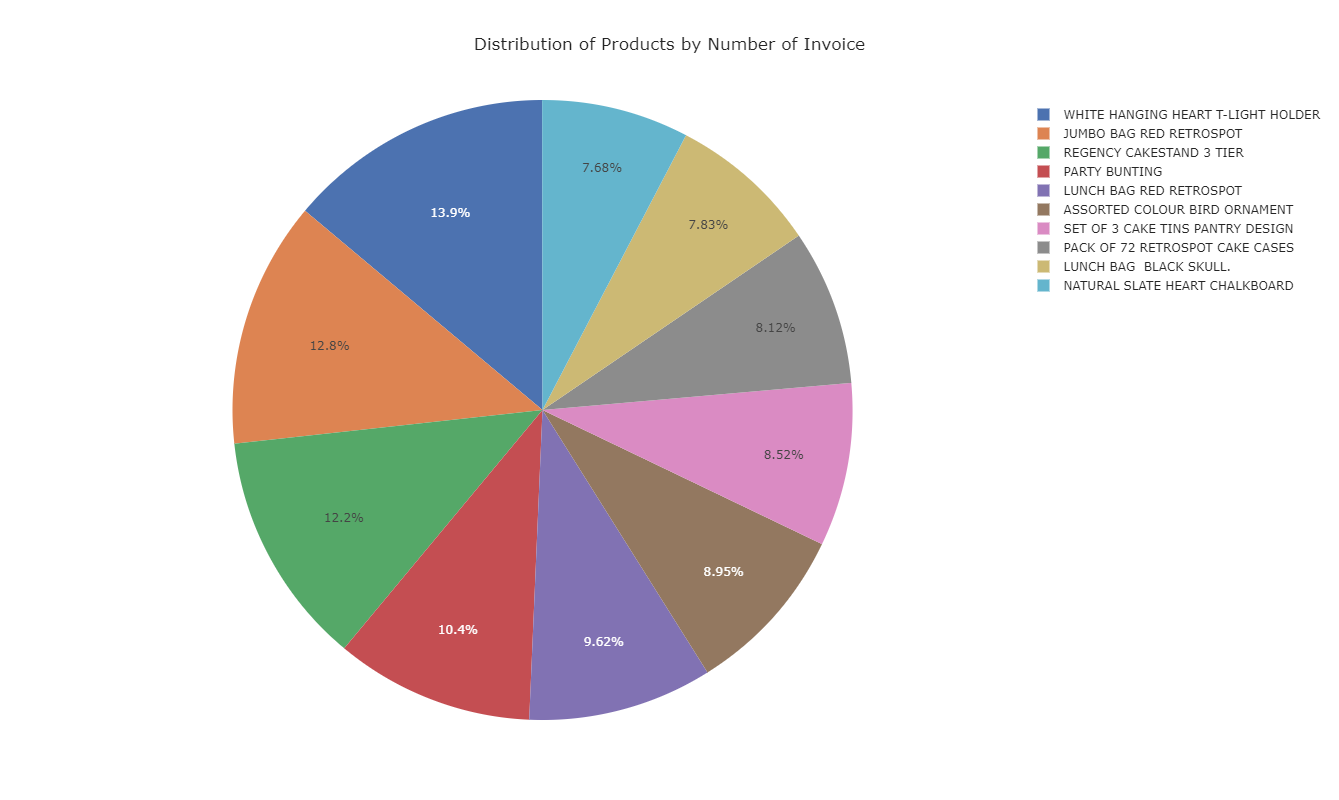

In [618]:
transactions = pd.DataFrame(df.groupby('Description').nunique().sort_values('InvoiceNo', ascending=False).head(10)['InvoiceNo'])

# pie plot
fig = px.pie(transactions,
             width = 800,
             height= 800,
             values=transactions['InvoiceNo'],
             names=transactions.index,
             title="Distribution of Products by Number of Invoice",
             template="seaborn")
fig.update_traces(rotation=-50, textinfo="percent")

fig.show()

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.

C:\Users\odete\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



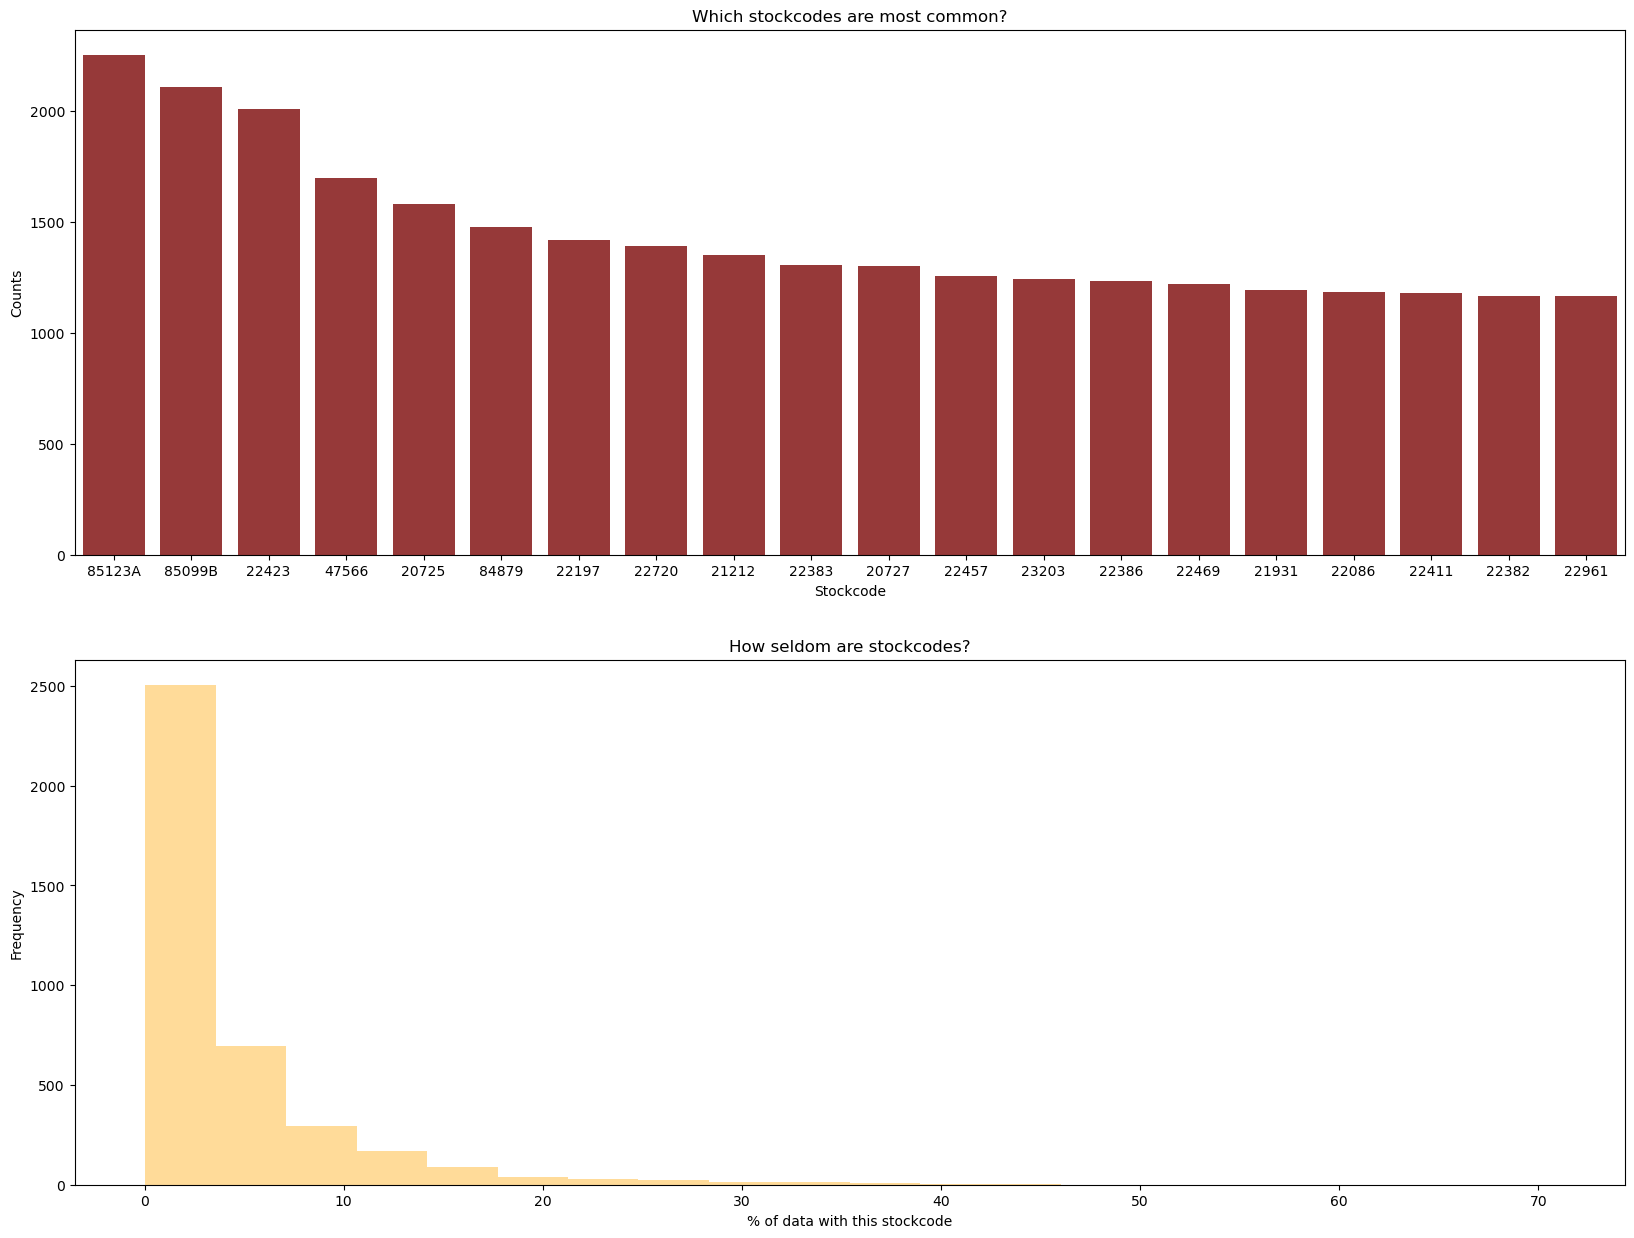

In [649]:
stockcode_counts = df.StockCode.value_counts().sort_values(ascending=False)
fig, ax = plt.subplots(2,1,figsize=(20,15))
sns.barplot(stockcode_counts.iloc[0:20].index,
            stockcode_counts.iloc[0:20].values,
            ax = ax[0], color = "brown")
ax[0].set_ylabel("Counts")
ax[0].set_xlabel("Stockcode")
ax[0].set_title("Which stockcodes are most common?");
sns.distplot(np.round(stockcode_counts/data.shape[0]*100,2),
             kde=False,
             bins=20,
             ax=ax[1], color="Orange")
ax[1].set_title("How seldom are stockcodes?")
ax[1].set_xlabel("% of data with this stockcode")
ax[1].set_ylabel("Frequency");

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



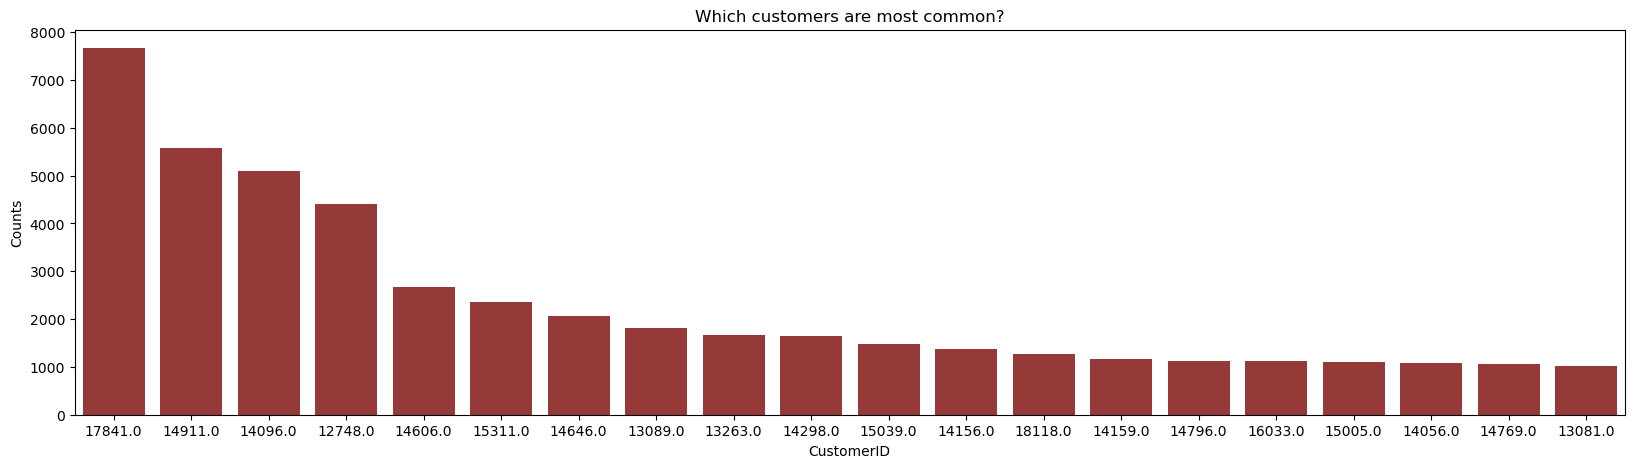

In [650]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending=False).iloc[0:20] 
plt.figure(figsize=(20,5))
sns.barplot(customer_counts.index, customer_counts.values, order=customer_counts.index, color = "brown")
plt.ylabel("Counts")
plt.xlabel("CustomerID")
plt.title("Which customers are most common?");
#plt.xticks(rotation=90);

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



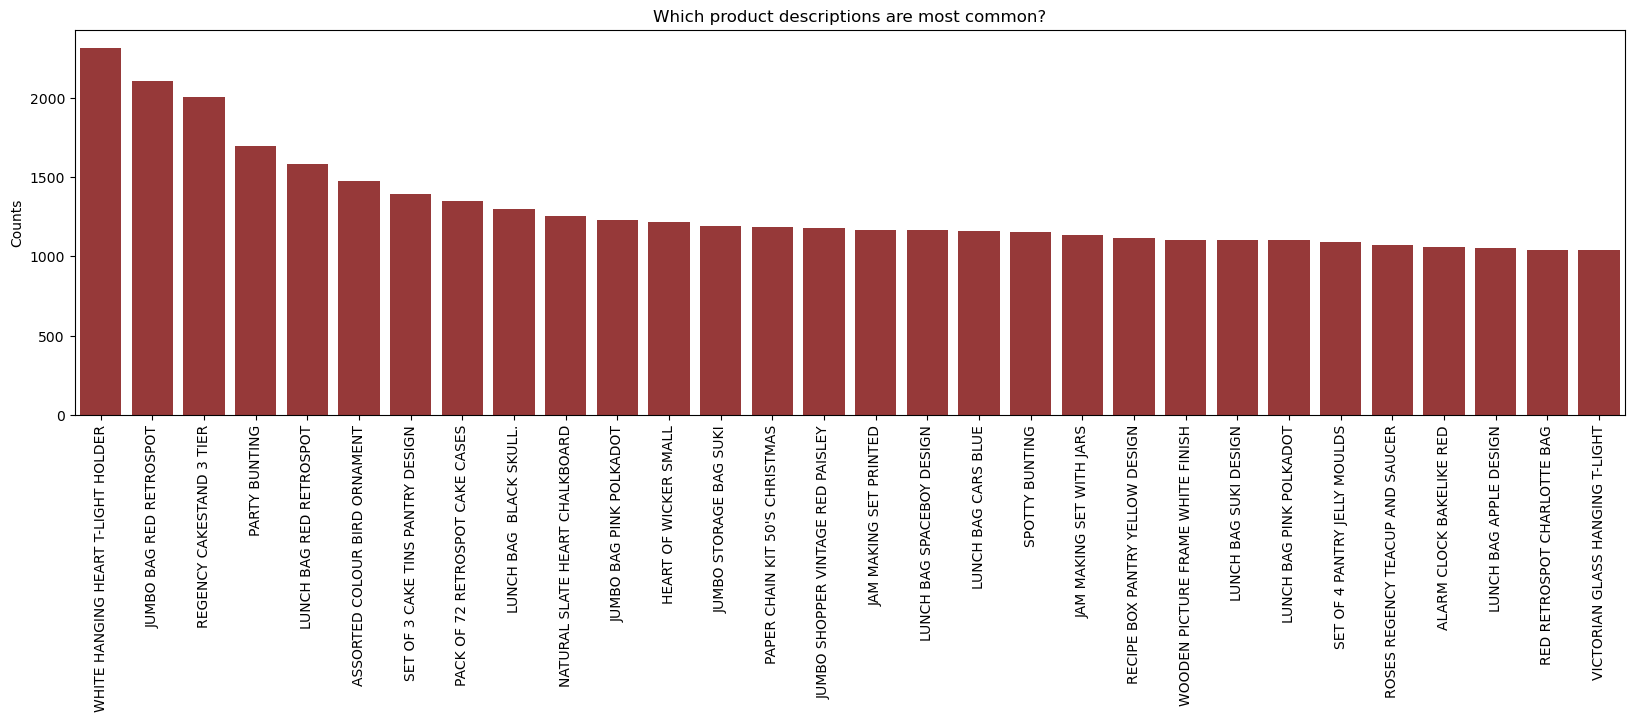

In [651]:
description_counts = df.Description.value_counts().sort_values(ascending=False).iloc[0:30]
plt.figure(figsize=(20,5))
sns.barplot(description_counts.index, description_counts.values, color = "brown")
plt.ylabel("Counts")
plt.title("Which product descriptions are most common?");
plt.xticks(rotation=90);

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



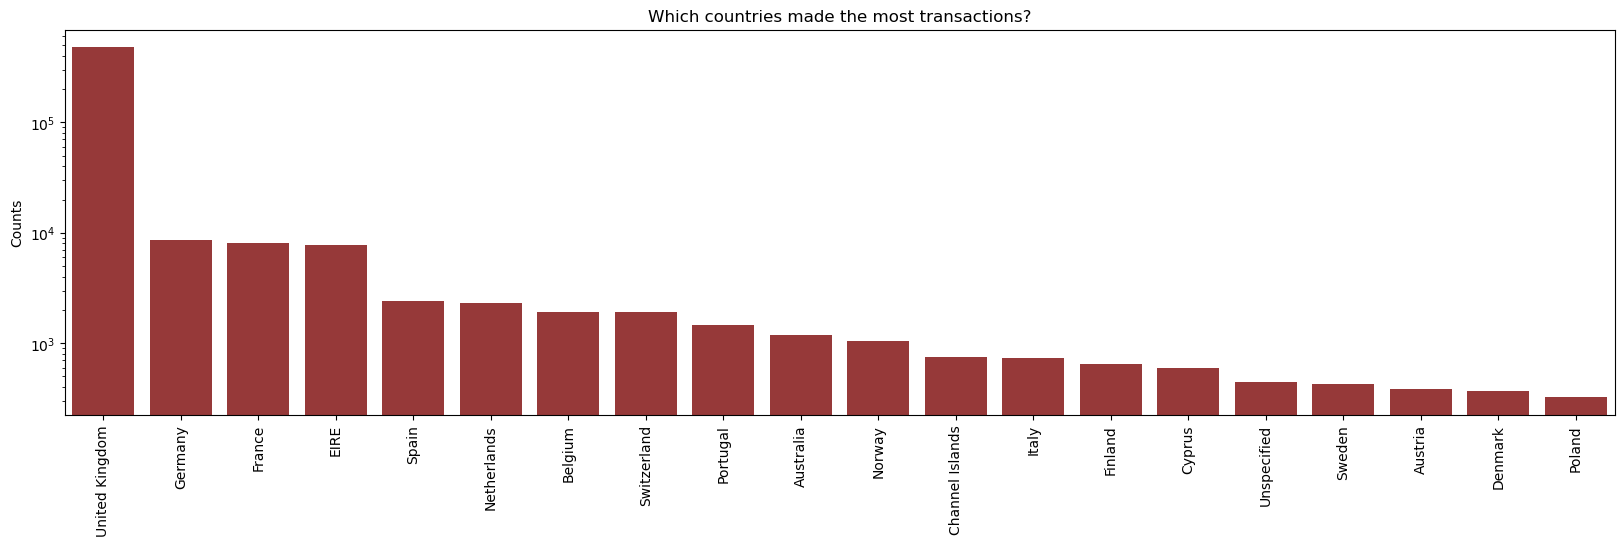

In [652]:
country_counts = df.Country.value_counts().sort_values(ascending=False).iloc[0:20]
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, color = "brown")
plt.ylabel("Counts")
plt.title("Which countries made the most transactions?");
plt.xticks(rotation=90);
plt.yscale("log")

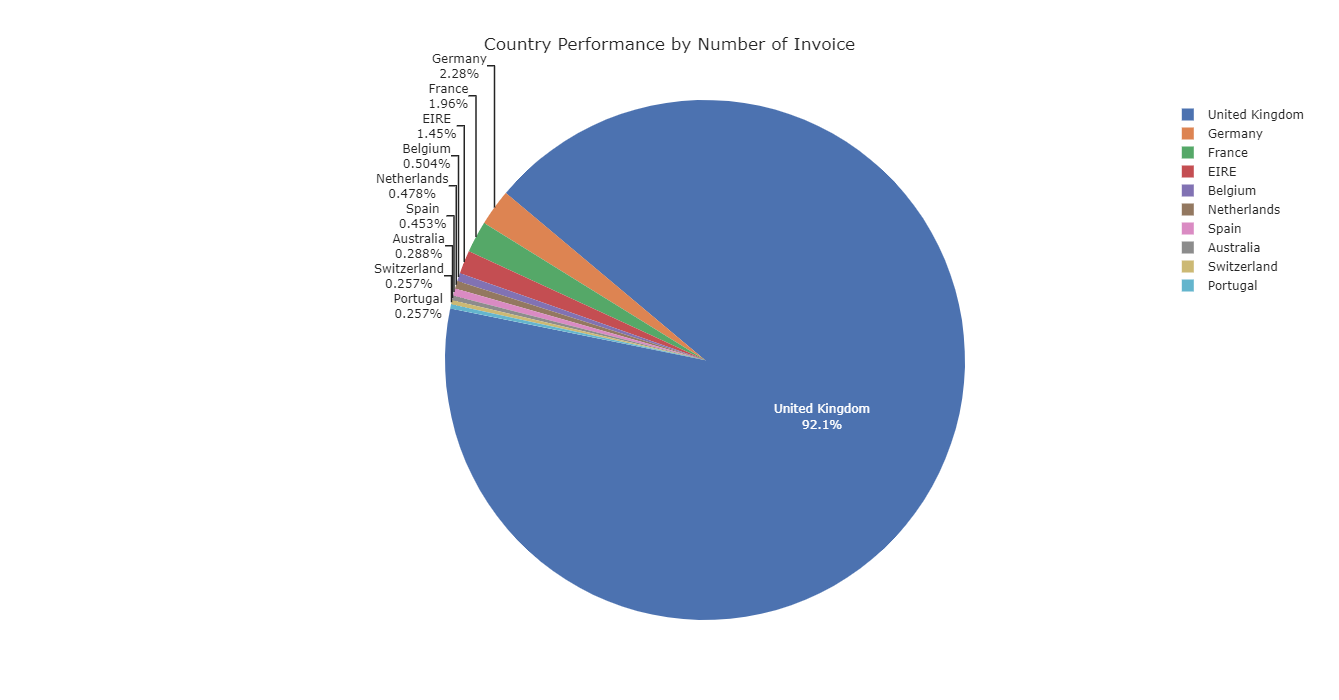

In [570]:
transactions = pd.DataFrame(df.groupby('Country').nunique().sort_values('InvoiceNo', ascending=False).head(10)['InvoiceNo'])

# pie plot
fig = px.pie(transactions,
             width = 700,
             height= 700,
             values=transactions['InvoiceNo'],
             names=transactions.index,
             title="Country Performance by Number of Invoice",
             template="seaborn")
fig.update_traces(rotation=-50, textinfo="percent+label")
fig.show()

In [627]:
df.reset_index(inplace = True)
df.drop(['index'], axis = 1, inplace = True)

In [628]:
### Split the date into date and hour

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

time=[]
for i in range (len(df['InvoiceDate'])):
    time1 = df['InvoiceDate'][i].hour
    time.append(time1)
    
week=[]
for i in range (len(df)):
    week1 = df['InvoiceDate'][i].weekday()
    week.append(week1)
    
df['Hour of the day']= time
df['Day of the week']= week
df['Day of the week']=df['Day of the week'].astype(str)

df['date'] = [w.date() for w in df['InvoiceDate']]
df['date'] = pd.to_datetime(df['date'])
df['hour'] = [w.time() for w in df['InvoiceDate']]

### Retrieve the month from the date
df['month'] = df['date'].dt.month
dict_col = {
            1 : 'january',
            2 : 'february',
            3 : 'march',
            4 : 'april',
            5 : 'may',
            6 : 'june',
            7 : 'july',
            8 : 'august',
            9 : 'september', 
            10 : 'october',
            11 : 'november',
            12 : 'december'
}

df['month'] = df['month'].apply(lambda x: dict_col[x])

df = df.drop('InvoiceDate', axis=1)

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



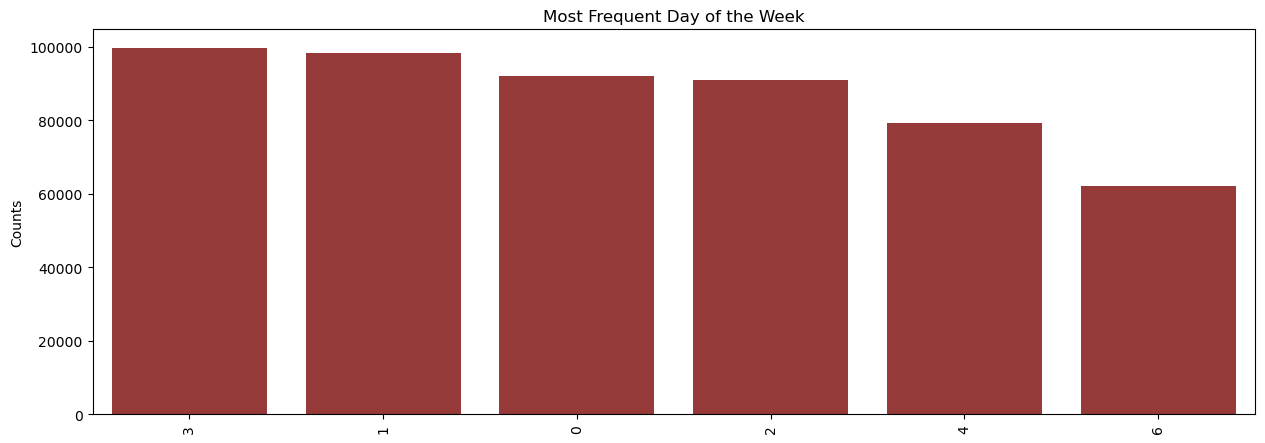

In [653]:
country_counts = df['Day of the week'].value_counts()
plt.figure(figsize=(15,5))
sns.barplot(country_counts.index, country_counts.values, color = "brown")
plt.ylabel("Counts")
plt.title("Most Frequent Day of the Week");
plt.xticks(rotation=90);

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



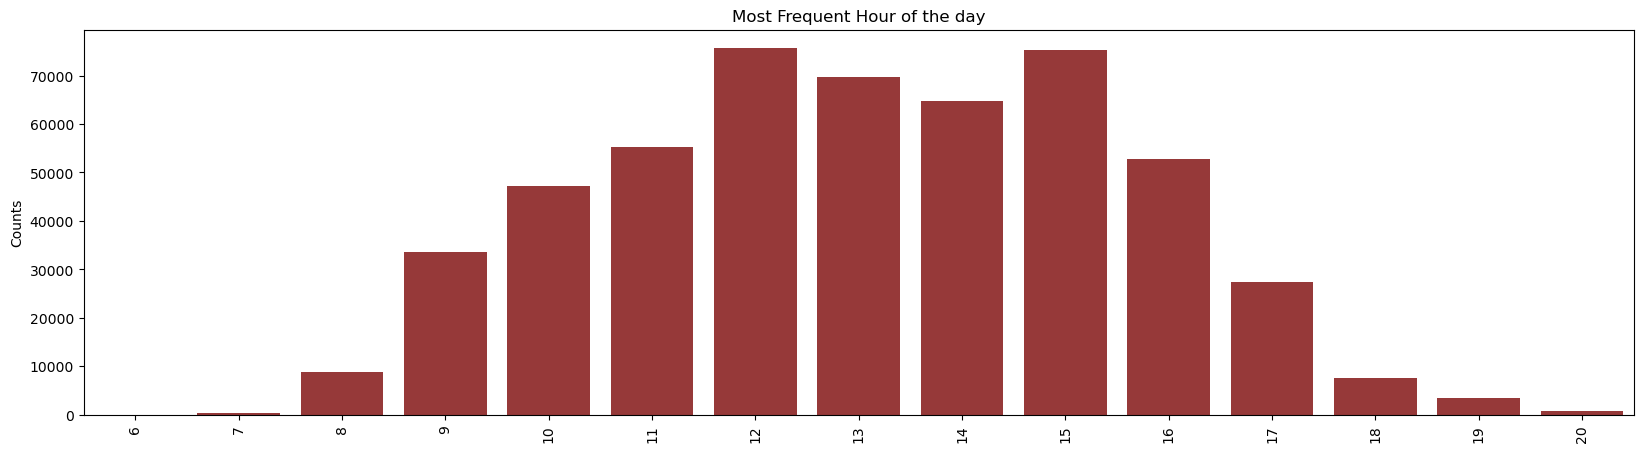

In [654]:
country_counts = df['Hour of the day'].value_counts()
plt.figure(figsize=(20,5))
sns.barplot(country_counts.index, country_counts.values, color = "brown")
plt.ylabel("Counts")
plt.title("Most Frequent Hour of the day");
plt.xticks(rotation=90);

C:\Users\odete\AppData\Local\Temp/ipykernel_23084/1402138531.py:10: FutureWarning:

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.

C:\Users\odete\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning:

Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.



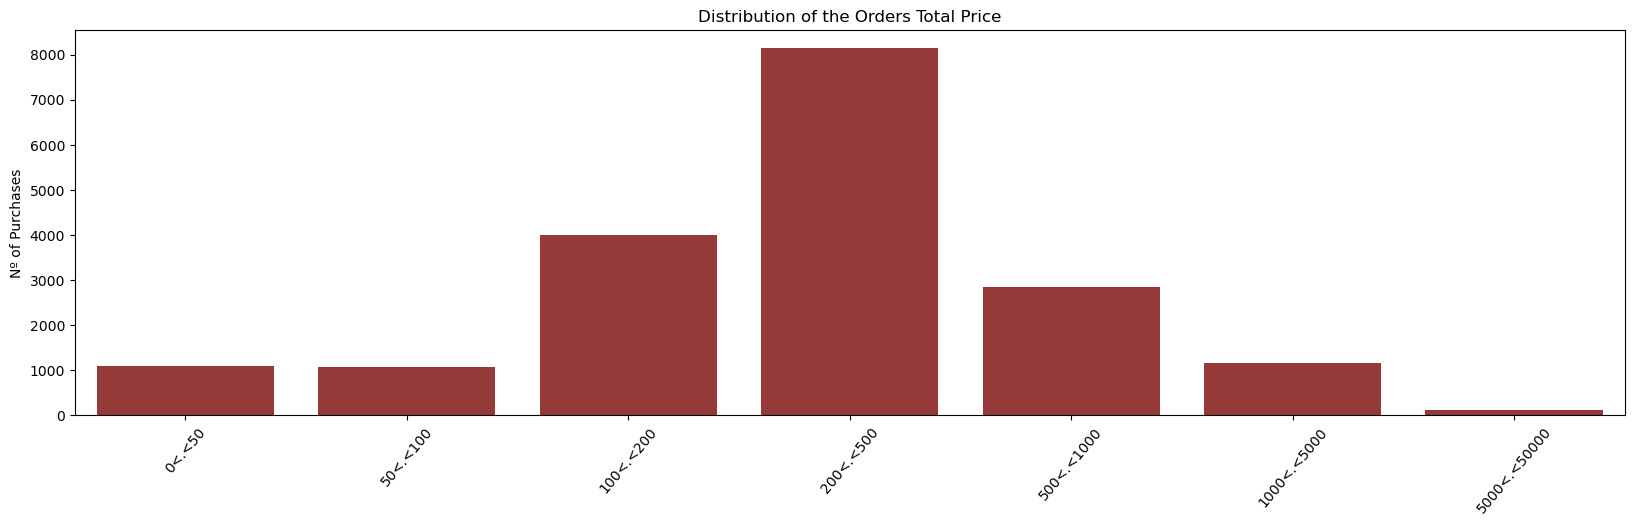

In [655]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

df['TotalPrice'] = df['UnitPrice'] * df['Quantity']

temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
 
df['InvoiceDate_int'] = df['date'].astype('int64')
temp = df.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df.drop('InvoiceDate_int', axis = 1, inplace = True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
 
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:6]

price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]
count_price = []
for i, price in enumerate(price_range):
    if i == 0: continue
    val = basket_price[(basket_price['Basket Price'] < price) &
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
labels = [ '{}<.<{}'.format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
y_pos = np.arange(len(labels))

plt.figure(figsize=(20,5))
sns.barplot(y_pos, count_price, color = "brown")
plt.ylabel("Nº of Purchases")
plt.xticks(y_pos, labels)
plt.title("Distribution of the Orders Total Price");
plt.xticks(rotation=50);
plt.show()

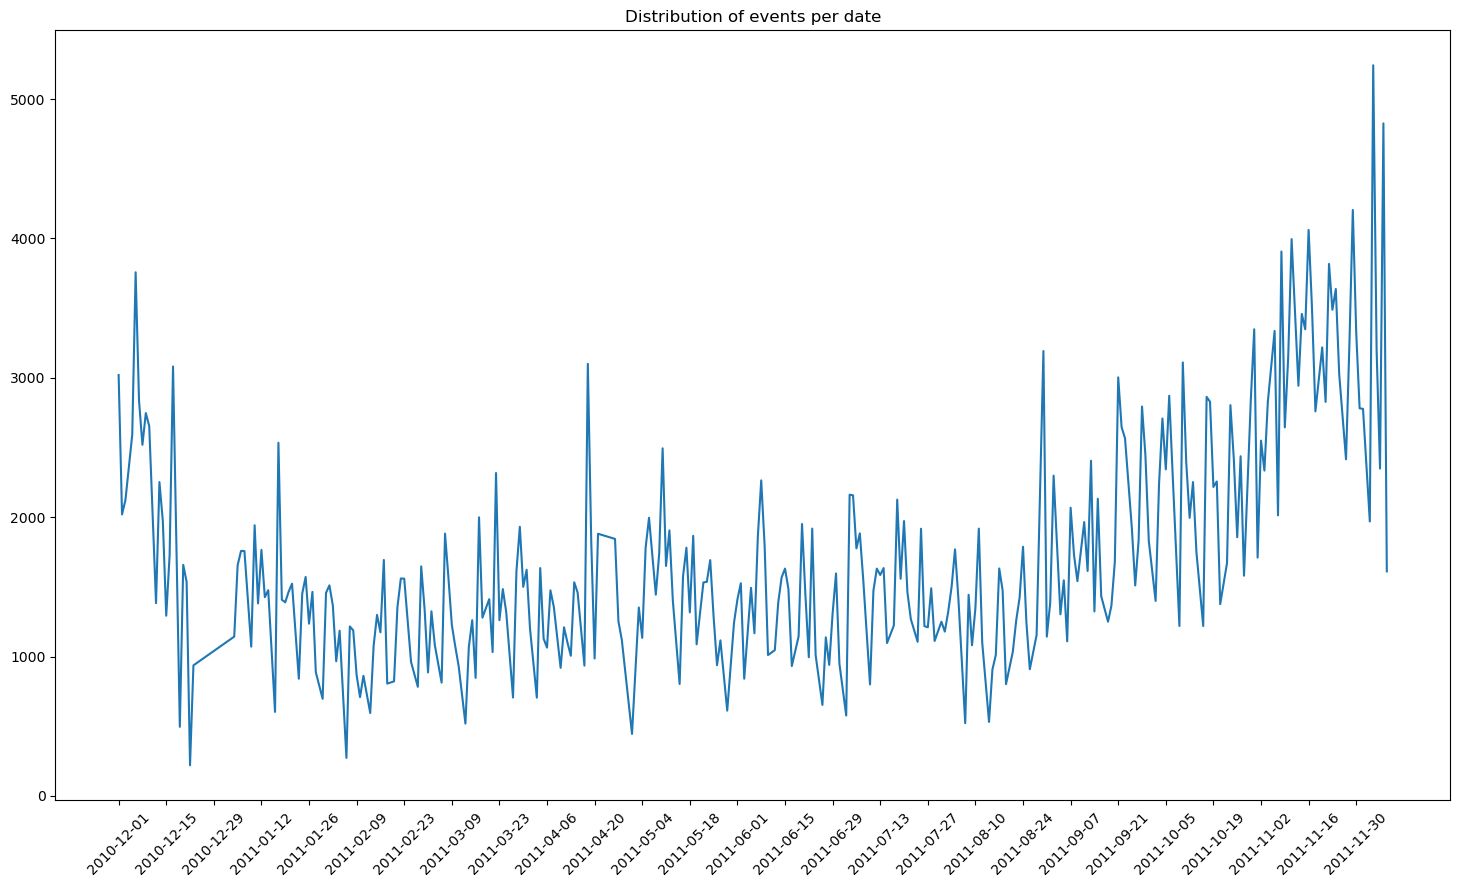

In [ ]:
### Analyse the influency of the date

df_freq = pd.DatetimeIndex(df['date']).normalize().value_counts().sort_index()
fig = plt.figure(figsize=(18,10))
plt.plot(df_freq.index, df_freq.values, linestyle="-")
plt.xticks(np.arange(df_freq.index[0], df_freq.index[-1], pd.to_timedelta(14, unit='d')), rotation=45)
plt.title('Distribution of events per date')
plt.show()

In [574]:
### Create a table for the the new customers

NewCustomers = df.loc[df['CustomerID'].isna()]
FreqCustomers = df.loc[~df['CustomerID'].isna()]
#df.dropna(inplace = True)
NewCustomers

,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country,StockCodeLen,date,hour,month,TotalPrice
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2.51,NaN,United Kingdom,5,2010-12-01,14:32:00,december,2.51
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2.51,NaN,United Kingdom,5,2010-12-01,14:32:00,december,5.02
1445,536544,21786,POLKADOT RAIN HAT,4,0.85,NaN,United Kingdom,5,2010-12-01,14:32:00,december,3.40
1446,536544,21787,RAIN PONCHO RETROSPOT,2,1.66,NaN,United Kingdom,5,2010-12-01,14:32:00,december,3.32
1447,536544,21790,VINTAGE SNAP CARDS,9,1.66,NaN,United Kingdom,5,2010-12-01,14:32:00,december,14.94
...,...,...,...,...,...,...,...,...,...,...,...,...
541535,581498,85049e,SCANDINAVIAN REDS RIBBONS,4,3.29,NaN,United Kingdom,6,2011-12-09,10:26:00,december,13.16
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,4.13,NaN,United Kingdom,6,2011-12-09,10:26:00,december,20.65
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,4.13,NaN,United Kingdom,6,2011-12-09,10:26:00,december,16.52
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,4.96,NaN,United Kingdom,5,2011-12-09,10:26:00,december,4.96


In [575]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 522504 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   InvoiceNo     522504 non-null  object        
 1   StockCode     522504 non-null  object        
 2   Description   522504 non-null  object        
 3   Quantity      522504 non-null  int64         
 4   UnitPrice     522504 non-null  float64       
 5   CustomerID    391150 non-null  float64       
 6   Country       522504 non-null  object        
 7   StockCodeLen  522504 non-null  int64         
 8   date          522504 non-null  datetime64[ns]
 9   hour          522504 non-null  object        
 10  month         522504 non-null  object        
 11  TotalPrice    522504 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(2), object(6)
memory usage: 51.8+ MB


<hr>

<a id="mba">
    
# 5. Market Basket Analysis
    
</a>
<br>


In [576]:
def encode_(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
basket_ = basket.applymap(encode_)
basket_

Description,10 COLOUR SPACEBOY PEN,12 COLOURED PARTY BALLOONS,12 DAISY PEGS IN WOOD BOX,12 EGG HOUSE PAINTED WOOD,12 HANGING EGGS HAND PAINTED,12 IVORY ROSE PEG PLACE SETTINGS,12 MESSAGE CARDS WITH ENVELOPES,12 PENCIL SMALL TUBE WOODLAND,12 PENCILS SMALL TUBE RED RETROSPOT,12 PENCILS SMALL TUBE SKULL,...,ZINC STAR T-LIGHT HOLDER,ZINC SWEETHEART SOAP DISH,ZINC SWEETHEART WIRE LETTER RACK,ZINC T-LIGHT HOLDER STAR LARGE,ZINC T-LIGHT HOLDER STARS LARGE,ZINC T-LIGHT HOLDER STARS SMALL,ZINC TOP 2 DOOR WOODEN SHELF,ZINC WILLIE WINKIE CANDLE STICK,ZINC WIRE KITCHEN ORGANISER,ZINC WIRE SWEETHEART LETTER TRAY
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581582,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581583,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581584,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [372]:
### 91.1% of the basket data is a transaction where more than 1 item is bought.

In [373]:
### Apriori algorithm is simply used to find the frequently bought items in the dataset

### Support: the percentage of transactions that contain all of the items in an itemset (e.g., pencil, paper and rubber). 
### The higher the support the more frequently the itemset occurs. Rules with a high support are preferred since they are likely to 
### be applicable to a large number of future transactions.



In [375]:
### There are 165 frequently bought items
### White hanging Heart T-Light Holder is the most frequently bought items with the support value of 0.122421. 
### It means the item is bought 2240 times out of the whole transaction.

- Lift:

In [ ]:
### The higher the lift value, the higher the association between the items willl. If the lift value is more than 1, 
### it is enough for us to say that those two items are associated each other. In this case, the highest value is 15.028 which is very high. 
### It means these 2 items are very good to be sold together.

- Support:

In [ ]:
### Beside that, we could also see the support value of ROSES REGENCY TEACUP AND SAUCER and GREEN REGENCY TEACUP AND SAUCER are 0.0.034518 which means 
### there are 3.16% out of total transaction that these 2 items were sold together ~ 632 (0.034518*18338)

- Confidence:

In [ ]:
### From the confidence, we could even extract more information, since the confidence value is influenced by the antecedent and consequent.
### If the antecedent is higher than the consequent, then the rule that will be applied is rule number 1 (not number 2). vice versa. 
### In this case, the antecedent value is higher than the consequent value. It means we will apply rule number 1. 
### In a more detail explanation, it means that a customer will tends to bought Roses Regency Teacup and Saucer AFTER they bought Green Regency Teacup And Saucer.

<a  id="uk">

## 5.1. UK Vs Rest of the World

</a>

- UK:

In [502]:
#First, we need to display the items into 1 transaction per rows with each product 1 hot-encoded
#We will first only do it with France to keep the dataset small
basket = (df[df['Country'] =="United Kingdom"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

basket_sets = basket.applymap(encode_)

In [503]:
#Filter the transaction that have more than 2 items bought, and to get rid of errors
basket_filter = basket_sets[(basket_sets > 0).sum(axis=1) >=2]
print(np.round(basket_filter.shape[0] / basket.shape[0]*100, 4),'% of the basket data is a transaction where more than 1 item is bought')

92.6775 % of the basket data is a transaction where more than 1 item is bought


In [504]:
#We apply the Apriori Algorithm with support 3%
frequent_itemsets = apriori(basket_filter, min_support=0.03, use_colnames=True).sort_values('support', ascending=False).reset_index(drop=True)

frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.121445,(WHITE HANGING HEART T-LIGHT HOLDER),1
1,0.093199,(JUMBO BAG RED RETROSPOT),1
2,0.090530,(REGENCY CAKESTAND 3 TIER),1
3,0.084478,(ASSORTED COLOUR BIRD ORNAMENT),1
4,0.082981,(PARTY BUNTING),1
...,...,...,...
104,0.030654,"(LUNCH BAG RED RETROSPOT, LUNCH BAG PINK POLKA...",2
105,0.030524,(SET OF 3 HEART COOKIE CUTTERS),1
106,0.030394,(DOLLY GIRL LUNCH BOX),1
107,0.030068,(GUMBALL COAT RACK),1


 - 42 transactions are considered as a frequently bought items. With WHITE HANGING HEART T-LIGHT HOLDER that is the most frequently bought items with the support value of 0.129946. It means the item is bought 2 364 times out of the whole transaction.

In [505]:
#Apply the Association rules
rulesuk = association_rules(frequent_itemsets, metric='lift', min_threshold=1).sort_values('lift', ascending=False).reset_index(drop=True)
rulesuk

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.043931,0.039831,0.030979,0.705185,17.704527,0.029230,3.256855
1,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.039831,0.043931,0.030979,0.777778,17.704527,0.029230,4.302310
2,(LUNCH BAG RED RETROSPOT),(LUNCH BAG PINK POLKADOT),0.072893,0.055125,0.030654,0.420536,7.628726,0.026636,1.630600
3,(LUNCH BAG PINK POLKADOT),(LUNCH BAG RED RETROSPOT),0.055125,0.072893,0.030654,0.556080,7.628726,0.026636,2.088457
4,(JUMBO BAG PINK POLKADOT),(JUMBO BAG RED RETROSPOT),0.052717,0.093199,0.032932,0.624691,6.702781,0.028019,2.416148
5,(JUMBO BAG RED RETROSPOT),(JUMBO BAG PINK POLKADOT),0.093199,0.052717,0.032932,0.353352,6.702781,0.028019,1.464912
6,(LUNCH BAG BLACK SKULL.),(LUNCH BAG RED RETROSPOT),0.064692,0.072893,0.031500,0.486922,6.679955,0.026785,1.806950
7,(LUNCH BAG RED RETROSPOT),(LUNCH BAG BLACK SKULL.),0.072893,0.064692,0.031500,0.432143,6.679955,0.026785,1.647082


In [506]:
rulesuk[rulesuk['confidence'] >= 0.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(ROSES REGENCY TEACUP AND SAUCER),(GREEN REGENCY TEACUP AND SAUCER),0.043931,0.039831,0.030979,0.705185,17.704527,0.02923,3.256855
1,(GREEN REGENCY TEACUP AND SAUCER),(ROSES REGENCY TEACUP AND SAUCER),0.039831,0.043931,0.030979,0.777778,17.704527,0.02923,4.302310


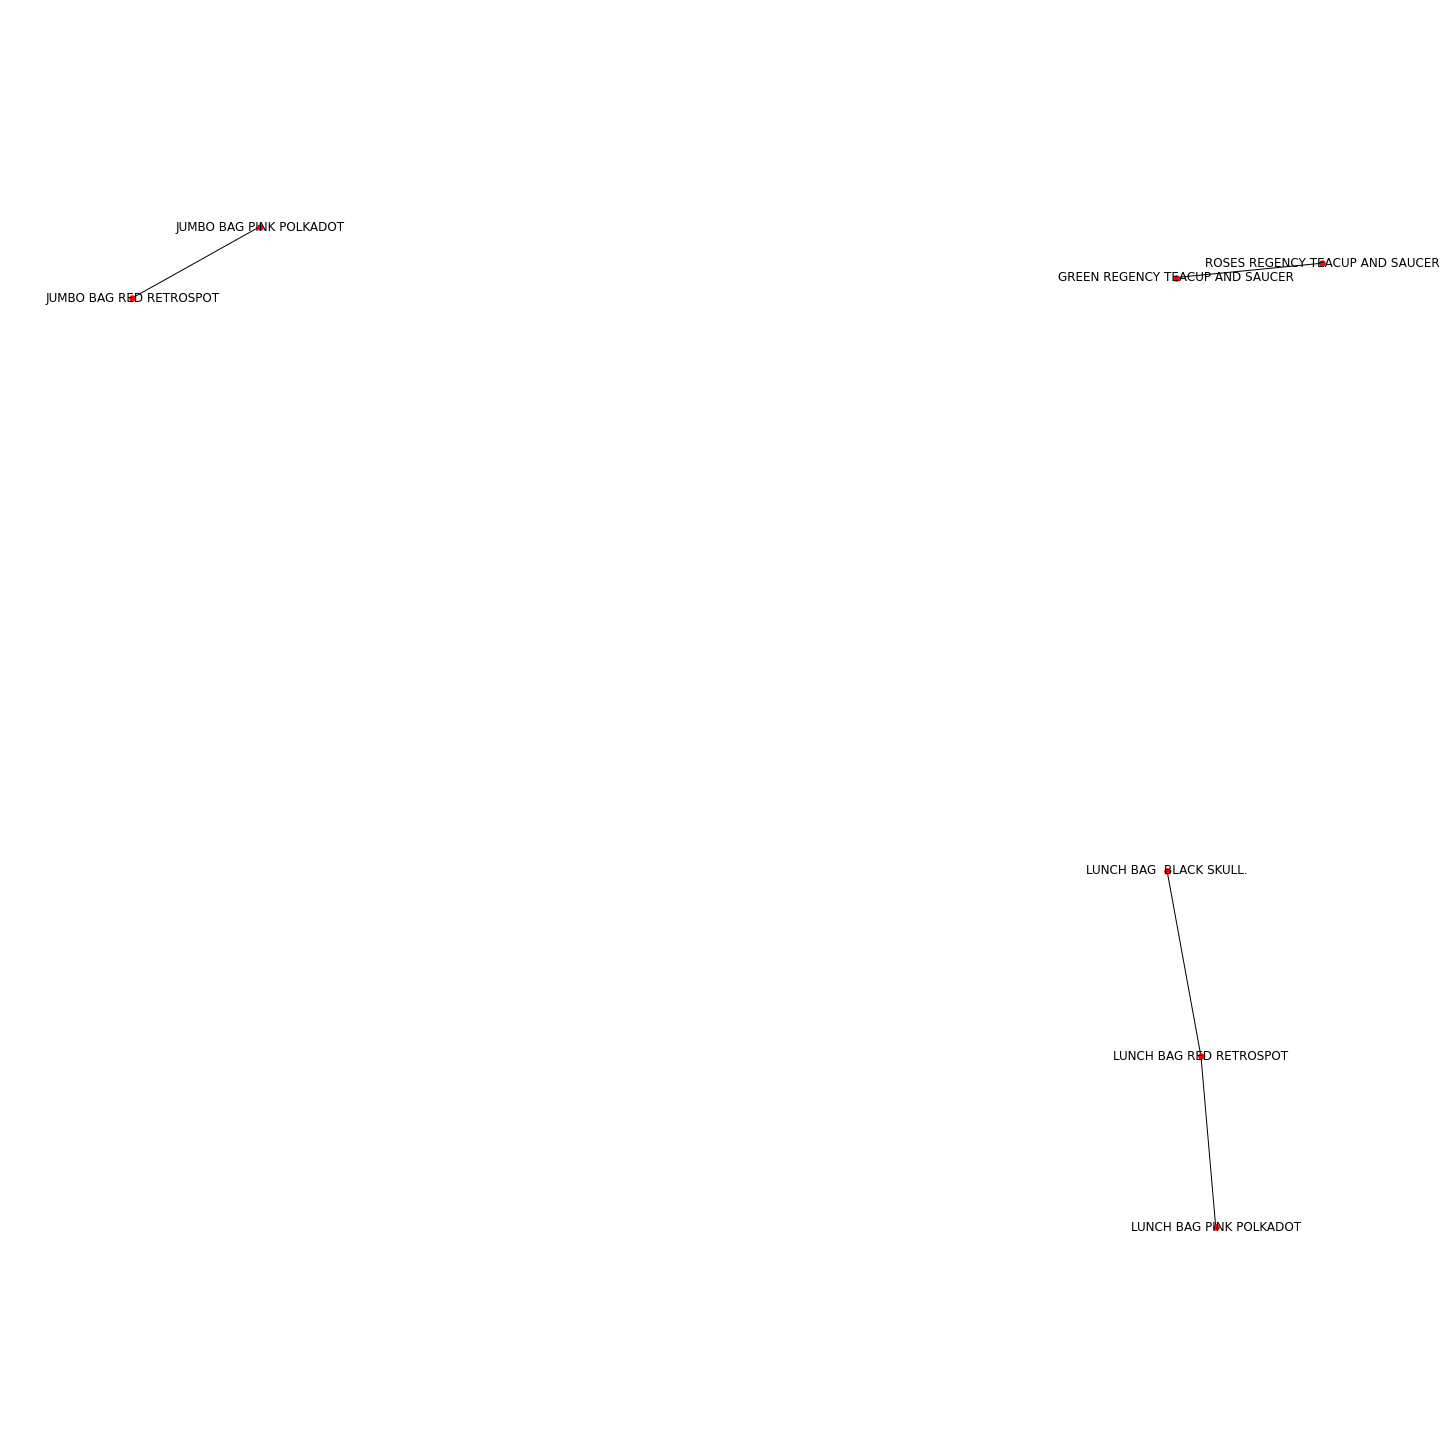

In [554]:
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rulesuk.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(20, 20)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()

- Rest of the World:

In [36]:
df.loc[df['Country'] != 'United Kingdom', 'Country'] = 'Rest of the World'

In [37]:
basket2 = (df[df['Country'] =="Rest of the World"]
          .groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

In [38]:
basket_sets2 = basket2.applymap(encode_)
basket2_filter = basket_sets2[(basket_sets2 > 0).sum(axis=1) >=2]
frequent_itemsets2 = apriori(basket2_filter, min_support=0.05, use_colnames=True)
frequent_itemsets2['length'] = frequent_itemsets2['itemsets'].apply(lambda x: len(x))
rules2 = association_rules(frequent_itemsets2, metric="lift", min_threshold=1)

In [39]:
frequent_itemsets2.head()

,support,itemsets,length
0,0.050934,(4 TRADITIONAL SPINNING TOPS),1
1,0.056593,(6 RIBBONS RUSTIC CHARM),1
2,0.058857,(ALARM CLOCK BAKELIKE GREEN),1
3,0.071873,(ALARM CLOCK BAKELIKE PINK),1
4,0.068478,(ALARM CLOCK BAKELIKE RED),1


In [40]:
rules2

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.085456,0.112620,0.063384,0.741722,6.586043,0.053760,3.435752
1,(SPACEBOY LUNCH BOX),(DOLLY GIRL LUNCH BOX),0.112620,0.085456,0.063384,0.562814,6.586043,0.053760,2.091889
2,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN SPACEBOY),0.115450,0.101302,0.054895,0.475490,4.693805,0.043200,1.713406
3,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN CIRCUS PARADE),0.101302,0.115450,0.054895,0.541899,4.693805,0.043200,1.930908
4,(PLASTERS IN TIN CIRCUS PARADE),(PLASTERS IN TIN WOODLAND ANIMALS),0.115450,0.123373,0.067346,0.583333,4.728211,0.053102,2.103905
5,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN CIRCUS PARADE),0.123373,0.115450,0.067346,0.545872,4.728211,0.053102,1.947797
6,(PLASTERS IN TIN SPACEBOY),(PLASTERS IN TIN WOODLAND ANIMALS),0.101302,0.123373,0.066780,0.659218,5.343294,0.054282,2.572397
7,(PLASTERS IN TIN WOODLAND ANIMALS),(PLASTERS IN TIN SPACEBOY),0.123373,0.101302,0.066780,0.541284,5.343294,0.054282,1.959162
8,(PLASTERS IN TIN WOODLAND ANIMALS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.123373,0.172043,0.052632,0.426606,2.479644,0.031406,1.443957
9,(ROUND SNACK BOXES SET OF4 WOODLAND),(PLASTERS IN TIN WOODLAND ANIMALS),0.172043,0.123373,0.052632,0.305921,2.479644,0.031406,1.263008


In [41]:
rules2[rules2['confidence'] >= 0.7]

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(DOLLY GIRL LUNCH BOX),(SPACEBOY LUNCH BOX),0.085456,0.112620,0.063384,0.741722,6.586043,0.053760,3.435752
10,(ROUND SNACK BOXES SET OF 4 FRUITS),(ROUND SNACK BOXES SET OF4 WOODLAND),0.104697,0.172043,0.079230,0.756757,4.398649,0.061218,3.403823
14,(SET/6 RED SPOTTY PAPER CUPS),(SET/6 RED SPOTTY PAPER PLATES),0.060555,0.061686,0.054329,0.897196,14.544457,0.050594,9.127232
15,(SET/6 RED SPOTTY PAPER PLATES),(SET/6 RED SPOTTY PAPER CUPS),0.061686,0.060555,0.054329,0.880734,14.544457,0.050594,7.876888


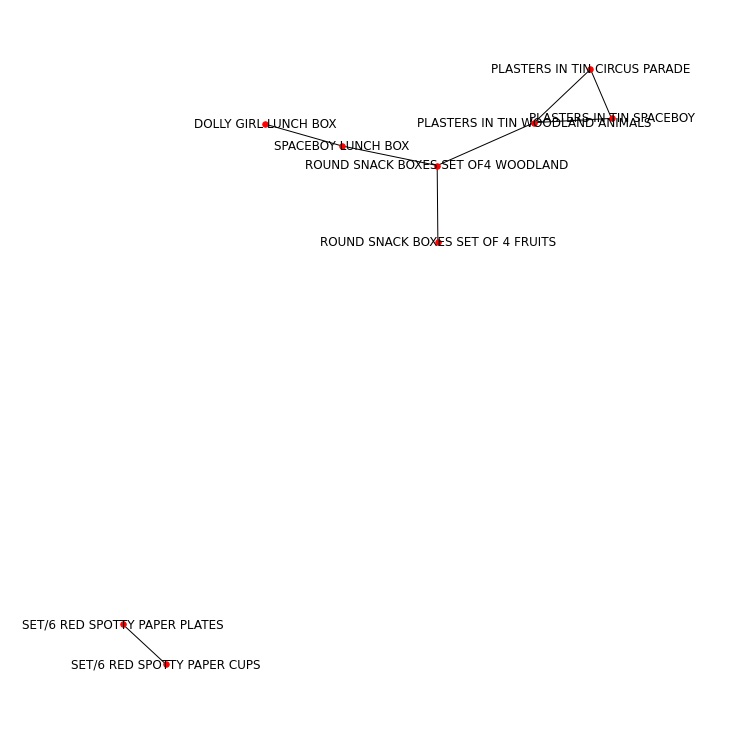

In [550]:
# Create a copy of the rules and transform the frozensets to strings
rulesToPlot = rules2.copy(deep=True)
rulesToPlot['LHS'] = [','.join(list(x)) for x in rulesToPlot['antecedents']]
rulesToPlot['RHS'] = [','.join(list(x)) for x in rulesToPlot['consequents']]
# Remove duplicate if reversed rules
rulesToPlot['sortedRow'] = [sorted([a,b]) for a,b in zip(rulesToPlot.LHS, rulesToPlot.RHS)]
rulesToPlot['sortedRow'] = rulesToPlot['sortedRow'].astype(str)
rulesToPlot.drop_duplicates(subset=['sortedRow'], inplace=True)
# Plot
rulesToPlot=rulesToPlot[:50]
fig = plt.figure(figsize=(10, 10)) 
G = nx.from_pandas_edgelist(rulesToPlot, 'LHS', 'RHS')  
# Each node is an itemset (either source or target) and the edges connect the itemsets if they consist of a high confidence rule
nx.draw(G, with_labels=True, node_size=30, node_color="red", pos=nx.spring_layout(G))
plt.axis('equal')
plt.show()

<hr>

<a id="rfm">
    
# 6. RFM Analysis
    
</a>
<br>


In [520]:
# this one is cooler to show:
# https://www.kaggle.com/code/brcsnt/rfm-analysis-with-e-commerce-data-and-using-plotly

In [527]:
most_recent_date = df.date.max()
rfm_table= df.groupby(by='CustomerID').aggregate({
    'date' : lambda x: (most_recent_date - x.max()).days,
    'InvoiceNo' : lambda x: len(x),
    'TotalPrice' : lambda x: sum(x)
})
rfm_table.columns = ['Recency', 'Frequency', 'Monetary']


In [528]:
#Frequency bulma
def FScore(x,p,d):
    if x <= d[p][0.20]:
        return 0
    elif x <= d[p][0.40]:
        return 1
    elif x <= d[p][0.60]: 
        return 2
    elif x <= d[p][0.80]:
        return 3
    else:
        return 4

quantiles = rfm_table.quantile(q=[0.20,0.40,0.60,0.80])
quantiles = quantiles.to_dict()
rfm_table['Freq_Tile'] = rfm_table['Frequency'].apply(FScore, args=('Frequency',quantiles,))

#Recency 
rfm_table = rfm_table.sort_values('Recency',ascending=True)
rfm_table['Rec_Tile'] = pd.qcut(rfm_table['Recency'],5,labels=False)

#Monetary 
rfm_table['Mone_Tile'] = pd.qcut(rfm_table['Monetary'],5,labels=False)

# instead of zero, plus 1 
rfm_table['Rec_Tile'] = rfm_table['Rec_Tile'] + 1
rfm_table['Freq_Tile'] = rfm_table['Freq_Tile'] + 1
rfm_table['Mone_Tile'] = rfm_table['Mone_Tile'] + 1

# Add to dataframe
rfm_table['RFM Score'] = rfm_table['Rec_Tile'].map(str) + rfm_table['Freq_Tile'].map(str) + rfm_table['Mone_Tile'].map(str)
rfm_table.head()

,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
16446.0,0,3,168472.50,1,1,5,115
17428.0,0,328,17256.85,5,1,5,155
16558.0,0,460,8338.49,5,1,5,155
17490.0,0,76,2092.32,4,1,5,145
12680.0,0,49,790.81,3,1,3,133


- First group is the group '555' which represents the best customers. Treatment is unnecessary because they are highly engaged - often make purchases,  do them a lot and spend a lot of money. However, tools for retaining them should be considered. Marketing strategy here could be to give them personalized offers (for instance, money coupons) based on their previous activity (purchases). Additional discounts may not be needed for this group due to their high involvement already.

In [529]:
rfm_table[rfm_table['RFM Score'] == '555'].sort_values('Monetary', ascending=False).head()


,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
13093.0,275,159,7832.47,5,5,5,555
17850.0,372,297,5391.21,5,5,5,555
15808.0,306,195,3651.27,5,5,5,555
13952.0,217,136,3251.07,5,5,5,555
17504.0,206,127,2997.03,5,5,5,555


- These customers are promising. Although, they make frequent purchases, it is possible to motivate them to spend more. Least expensive strategy here can be reminders - e-mail notifications, for instance, in cases when there are items in the cart but the customer haven't bought them or remind the customer about his recent search queries. Special offers can also be considered here to increase engagement and thus monetary value.

In [545]:
#Customers who's recency value is low
rfm_table[(rfm_table['Mone_Tile'] <= 2) & (rfm_table['Freq_Tile'] >= 4)].sort_values('Monetary', ascending=False).head()

,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
17950.0,72,71,482.20,4,4,2,442,10,Can't Loose Them
13176.0,46,67,481.49,4,3,2,342,9,Can't Loose Them
14130.0,319,66,480.91,4,5,2,542,11,Can't Loose Them
17555.0,19,105,480.31,4,2,2,242,8,Champions
16368.0,2,69,479.91,4,1,2,142,7,Loyal


- These customers are lost. They have made a few orders and haven't been active recently. Cost-effective treatment can be a company newsletter (with new in-stock products, new services, etc.)

In [531]:
#Customers who's recency, frequency as well as monetary values are low 
rfm_table[rfm_table['RFM Score'] == '111'].sort_values('Recency',ascending=False).head()

,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
14946.0,14,3,100.9,1,1,1,111
16856.0,14,2,35.4,1,1,1,111
13188.0,11,2,114.6,1,1,1,111
12660.0,11,12,227.1,1,1,1,111
17468.0,10,5,137.0,1,1,1,111


- Most of income has been generated by these customers. They are willing to pay, so attracting strategies should be considered. For instance, premium product offers, service of premium quality, high-level subscriptions, etc. to improve AOV (average order value). Coupons and discounts are out of consideration, so investments may be safed here.

In [547]:
rfm_table[rfm_table['Mone_Tile'] == 5 ].sort_values('Monetary', ascending=False).head()


,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
14646.0,1,2060,279138.02,5,1,5,155,11,Can't Loose Them
18102.0,0,431,259657.30,5,1,5,155,11,Can't Loose Them
17450.0,8,336,194390.79,5,1,5,155,11,Can't Loose Them
16446.0,0,3,168472.50,1,1,5,115,7,Loyal
14911.0,1,5584,136161.83,5,1,5,155,11,Can't Loose Them


- These customers are loyal since they frequently make purchase. Their monetary value can be increased by offering them loyalty programs (personalized discounts, cash back, free shipping) or in case of small investments, promotional newsletters.

In [532]:
rfm_table[rfm_table['Freq_Tile'] >= 3 ].sort_values('Monetary', ascending=False).head()


,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score
CustomerID,,,,,,,
14646.0,1,2060,279138.02,5,1,5,155
18102.0,0,431,259657.30,5,1,5,155
17450.0,8,336,194390.79,5,1,5,155
14911.0,1,5584,136161.83,5,1,5,155
12415.0,24,713,124564.53,5,2,5,255


- Newbie customers. Triggered emails can be applied as a strategy to motivate customers to new purchases. Loyalty program will be an advantage to move this group of customers from F-3 to F-1. The sooner they will be a part of such program the more there will be possibilities to engage them with special offers and the faster further engagement approaches can be implemented.

In [548]:
rfm_table[(rfm_table['Rec_Tile'] >= 5) &  (rfm_table['Freq_Tile'] <= 2)].sort_values('Monetary', ascending=False).head()


,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
12346.0,325,1,77183.60,1,5,5,515,11,Can't Loose Them
15749.0,235,10,44534.30,1,5,5,515,11,Can't Loose Them
15098.0,182,3,39916.50,1,5,5,515,11,Can't Loose Them
12755.0,280,4,3811.95,1,5,5,515,11,Can't Loose Them
18087.0,290,1,3202.92,1,5,5,515,11,Can't Loose Them


In [533]:
# Calculate RFM_Score
rfm_table['RFM_Sum'] = rfm_table[['Freq_Tile','Rec_Tile','Mone_Tile']].sum(axis=1)
rfm_table.head()

,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum
CustomerID,,,,,,,,
16446.0,0,3,168472.50,1,1,5,115,7
17428.0,0,328,17256.85,5,1,5,155,11
16558.0,0,460,8338.49,5,1,5,155,11
17490.0,0,76,2092.32,4,1,5,145,10
12680.0,0,49,790.81,3,1,3,133,7


In [534]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Sum'] >= 9:
        return 'Can\'t Loose Them'
    elif ((df['RFM_Sum'] >= 8) and (df['RFM_Sum'] < 9)):
        return 'Champions'
    elif ((df['RFM_Sum'] >= 7) and (df['RFM_Sum'] < 8)):
        return 'Loyal'
    elif ((df['RFM_Sum'] >= 6) and (df['RFM_Sum'] < 7)):
        return 'Potential'
    elif ((df['RFM_Sum'] >= 5) and (df['RFM_Sum'] < 6)):
        return 'Promising'
    elif ((df['RFM_Sum'] >= 4) and (df['RFM_Sum'] < 5)):
        return 'Needs Attention'
    else:
        return 'Require Activation'
# Create a new variable RFM_Level
rfm_table['RFM_Level'] = rfm_table.apply(rfm_level, axis=1)
# Print the header with top 5 rows to the console
rfm_table.head()

,Recency,Frequency,Monetary,Freq_Tile,Rec_Tile,Mone_Tile,RFM Score,RFM_Sum,RFM_Level
CustomerID,,,,,,,,,
16446.0,0,3,168472.50,1,1,5,115,7,Loyal
17428.0,0,328,17256.85,5,1,5,155,11,Can't Loose Them
16558.0,0,460,8338.49,5,1,5,155,11,Can't Loose Them
17490.0,0,76,2092.32,4,1,5,145,10,Can't Loose Them
12680.0,0,49,790.81,3,1,3,133,7,Loyal


In [535]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = rfm_table.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': ['mean', 'count']}).round(1)
# Print the aggregated dataset
print(rfm_level_agg)

                   Recency Frequency Monetary      
                      mean      mean     mean count
RFM_Level                                          
Can't Loose Them      85.5     139.4   3118.9  2531
Champions            118.0      30.8    541.4   550
Loyal                141.4      19.9    627.9   638
Needs Attention       18.3       9.2    175.4    88
Potential             66.3      16.5    269.4   308
Promising             32.9      13.9    225.9   184
Require Activation     6.6       6.5    143.8    35


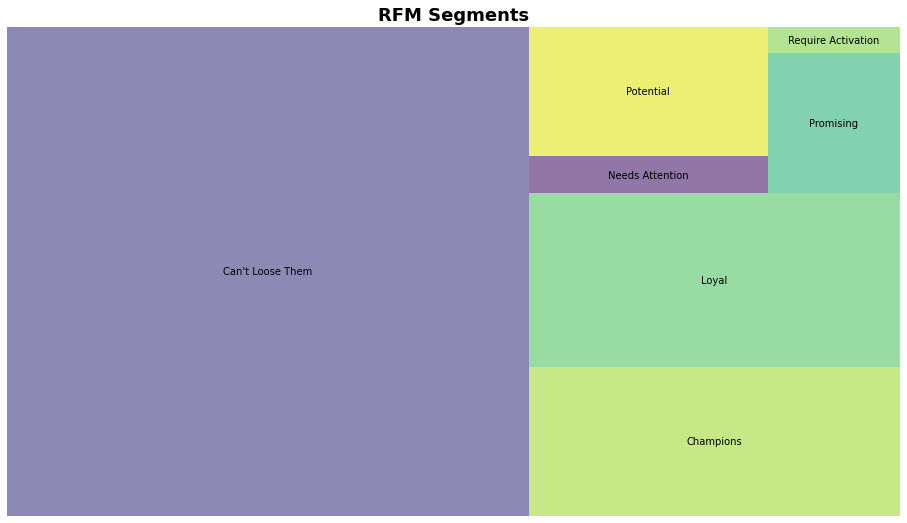

In [542]:
#rfm_level_agg.columns = rfm_level_agg.columns.droplevel()
rfm_level_agg.columns = ['RecencyMean','FrequencyMean','MonetaryMean', 'Count']
#Create our plot and resize it.
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 9)
squarify.plot(sizes=rfm_level_agg['Count'], 
              label=['Can\'t Loose Them',
                     'Champions',
                     'Loyal',
                     'Needs Attention',
                     'Potential', 
                     'Promising', 
                     'Require Activation'], alpha=.6 )
plt.title("RFM Segments",fontsize=18,fontweight="bold")
plt.axis('off')
plt.show()

<hr>

<a id="model">
    
# 7. Model
    
</a>
<br>


<a  id="sparse">

## 7.1. Reducing Sparsity

</a>

In [486]:
df.dropna(inplace = True)

In [487]:
def threshold_ratings(df, uid_min, iid_min, max_iter=None):
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Raw dataset info \n-----------------')
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    
    done, i = False, 0
    while not done:
        # When we exclude users with freq less than uid_min we might end up with new 
        # items with freq less than iid_min, so we will have to alternate back and forth
        starting_shape = df.shape[0]  # number of existing events

        uid_counts = df.groupby('CustomerID').size()  # user id frequencies
        df = df[~df['CustomerID'].isin(uid_counts[uid_counts < uid_min].index.tolist())]  # keep events with users with frequency >= uid_min

        iid_counts = df.groupby('StockCode').size()  # item id frequencies
        df = df[~df['StockCode'].isin(iid_counts[iid_counts < iid_min].index.tolist())]  # keep events with items with frequency >= iid_min

        ending_shape = df.shape[0]  # number of existing events after filters
        i += 1
        if starting_shape == ending_shape or i == max_iter:  # convergence happens
            done = True
    
    if not max_iter:
        assert(df.groupby('CustomerID').size().min() >= uid_min)
        assert(df.groupby('StockCode').size().min() >= iid_min)
    
    n_users = df['CustomerID'].nunique()
    n_items = df['StockCode'].nunique()
    sparsity = float(df.shape[0]) / float(n_users * n_items) * 100
    print('Limited dataset info \n-----------------')
    print('Number of iterations until convergence: {}'.format(i))
    print('Number of users: {}'.format(n_users))
    print('Number of items: {}'.format(n_items))
    print('Sparsity: {:4.3f}%'.format(sparsity))
    return df

df_limited = threshold_ratings(df, 5, 5)

Raw dataset info 
-----------------
Number of users: 4334
Number of items: 3659
Sparsity: 2.467%
Limited dataset info 
-----------------
Number of iterations until convergence: 3
Number of users: 4105
Number of items: 3182
Sparsity: 2.983%


In [488]:
df_limited.reset_index(inplace = True)

df_limited.drop(['index'], axis = 1, inplace = True)

<a  id="tts">

## 7.2. Train-Test Split

</a>

In [385]:
##### OPTION 1

#train = df[(df['date'] > '2010-12-01') & (df['date'] <= '2011-10-20')]

#test = df[(df['date'] > '2011-10-20') & (df['date'] <= '2011-12-09')]

#print(' The train set represents about ' + str(round(len(train)/len(df)*100)) + '% of the data.' )

In [590]:
##### OPTION 2

start_train = df_limited['date'].min()
start_test = start_train + pd.to_timedelta(15, unit='w')
end_test = start_test + pd.to_timedelta(5, unit='w')

df_limited = df_limited.loc[(df_limited['date'] > start_train) & (df_limited['date'] <= end_test)]

df_limited['train_split'] = (df_limited['date'] <= start_test).astype(int)
print("Proportion of train events: {:.2f}".format(df_limited['train_split'].mean()))

Proportion of train events: 0.71


In [387]:
#df_limited['train_split'].value_counts()


<a  id="als">

## 7.3. Alternating Least Squares (ALS)

</a>

- Functions:

In [388]:
def implicit_als(sparse_data, alpha_val=40, iterations=30, lambda_val=0.1, features=10):
 
    """ Implementation of Alternating Least Squares with implicit data. We iteratively
    compute the user (x_u) and item (y_i) vectors using the following formulas:
 
    x_u = ((Y.T*Y + Y.T*(Cu - I) * Y) + lambda*I)^-1 * (X.T * Cu * p(u))
    y_i = ((X.T*X + X.T*(Ci - I) * X) + lambda*I)^-1 * (Y.T * Ci * p(i))
 
    Args:
        sparse_data (csr_matrix): Our sparse user-by-item matrix
 
        alpha_val (int): The rate in which we'll increase our confidence
        in a preference with more interactions.
 
        iterations (int): How many times we alternate between fixing and 
        updating our user and item vectors
 
        lambda_val (float): Regularization value
 
        features (int): How many latent features we want to compute.
    
    Returns:     
        X (csr_matrix): user vectors of size users-by-features
        
        Y (csr_matrix): item vectors of size items-by-features
     """

    # Calculate the foncidence for each value in our data
    confidence = sparse_data * alpha_val
    
    # Get the size of user rows and item columns
    user_size, item_size = sparse_data.shape
    
    # We create the user vectors X of size users-by-features, the item vectors
    # Y of size items-by-features and randomly assign the values.
    X = sparse.csr_matrix(np.random.normal(size = (user_size, features)))
    Y = sparse.csr_matrix(np.random.normal(size = (item_size, features)))
    
    #Precompute I and lambda * I
    X_I = sparse.eye(user_size)
    Y_I = sparse.eye(item_size)
    
    I = sparse.eye(features)
    lI = lambda_val * I
    # Start main loop. For each iteration we first compute X and then Y
    for i in range(iterations):
        print ('iteration %d of %d' % (i+1, iterations))
        
        # Precompute Y-transpose-Y and X-transpose-X
        yTy = Y.T.dot(Y)
        xTx = X.T.dot(X)

        # Loop through all users
        for u in range(user_size):

            # Get the user row.
            u_row = confidence[u,:].toarray() 

            # Calculate the binary preference p(u)
            p_u = u_row.copy()
            p_u[p_u != 0] = 1.0

            # Calculate Cu and Cu - I
            CuI = sparse.diags(u_row, [0])
            Cu = CuI + Y_I

            # Put it all together and compute the final formula
            yT_CuI_y = Y.T.dot(CuI).dot(Y)
            yT_Cu_pu = Y.T.dot(Cu).dot(p_u.T)
            X[u] = spsolve(yTy + yT_CuI_y + lI, yT_Cu_pu)

    
        for i in range(item_size):

            # Get the item column and transpose it.
            i_row = confidence[:,i].T.toarray()

            # Calculate the binary preference p(i)
            p_i = i_row.copy()
            p_i[p_i != 0] = 1.0

            # Calculate Ci and Ci - I
            CiI = sparse.diags(i_row, [0])
            Ci = CiI + X_I

            # Put it all together and compute the final formula
            xT_CiI_x = X.T.dot(CiI).dot(X)
            xT_Ci_pi = X.T.dot(Ci).dot(p_i.T)
            Y[i] = spsolve(xTx + xT_CiI_x + lI, xT_Ci_pi)

    return X, Y

In [389]:
def recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup, num_items=10):
    """Recommend items for a given user given a trained model
    
    Args:
        user_id (int): The id of the user we want to create recommendations for.
        
        data_sparse (csr_matrix): Our original training data.
        
        user_vecs (csr_matrix): The trained user x features vectors
        
        item_vecs (csr_matrix): The trained item x features vectors
        
        item_lookup (pandas.DataFrame): Used to map artist ids to artist names
        
        num_items (int): How many recommendations we want to return:
        
    Returns:
        recommendations (pandas.DataFrame): DataFrame with num_items artist names and scores
    
    """
  
    # Get all interactions by the user
    user_interactions = data_sparse[user_id,:].toarray()

    # We don't want to recommend items the user has consumed. So let's
    # set them all to 0 and the unknowns to 1.
    user_interactions = user_interactions.reshape(-1) + 1 #Reshape to turn into 1D array
    user_interactions[user_interactions > 1] = 0
    rec_vector = user_vecs[user_id,:].dot(item_vecs.T).toarray()

    # Let's scale our scores between 0 and 1 to make it all easier to interpret.
    min_max = MinMaxScaler()
    rec_vector_scaled = min_max.fit_transform(rec_vector.reshape(-1,1))[:,0]
    recommend_vector = user_interactions*rec_vector_scaled
   
    # Get all the artist indices in order of recommendations (descending) and
    # select only the top "num_items" items. 
    item_idx = np.argsort(recommend_vector)[::-1][:num_items]

    items = []
    scores = []

    # Loop through our recommended artist indicies and look up the actial artist name
    for idx in item_idx:
        items.append(item_lookup.StockCode.loc[item_lookup.item_id == str(idx)].iloc[0])
        scores.append(recommend_vector[idx])

    # Create a new dataframe with recommended artist names and scores
    recommendations = pd.DataFrame({'item': items, 'score': scores})
    
    return recommendations

In [390]:
# Convert customers names into numerical IDs
df_limited['CustomerID'] = df_limited['CustomerID'].astype("category")
d_customer = dict(enumerate(df_limited['CustomerID'].cat.categories))

# Convert items names into numerical IDs
df_limited['StockCode'] = df_limited['StockCode'].astype("category")
d_item = dict(enumerate(df_limited['StockCode'].cat.categories))

df_limited['user_id'] = df_limited['CustomerID'].astype("category").cat.codes
df_limited['item_id'] = df_limited['StockCode'].astype("category").cat.codes

# Create a lookup frame so we can get the artist names back in 
# readable form later.
item_lookup = df_limited[['item_id', 'StockCode']].drop_duplicates()
item_lookup['item_id'] = item_lookup.item_id.astype(str)

# Create lists of all users, items and quantities
users = list(np.sort(df_limited.user_id.unique()))
items = list(np.sort(df_limited.item_id.unique()))
quantity = list(df_limited.Quantity)

# Get the rows and columns for our new matrix
rows = df_limited.user_id
cols = df_limited.item_id

# Contruct a sparse matrix for our users and items containing number of plays
data_sparse = sparse.csr_matrix((quantity, (rows, cols)), shape=(len(users), len(items)))

In [429]:
def rec_sys(customer):
    ###
    user_vecs, item_vecs = implicit_als(data_sparse, iterations=10,features=40, alpha_val=40)
    
    ###
    user_id = [k for k, v in d_customer.items() if v == customer][0]
    recommendations = recommend(user_id, data_sparse, user_vecs, item_vecs, item_lookup)
    #recommendations['item'] = recommendations['item'].apply(lambda x: d_item[x])
    
    return recommendations 

In [392]:
rec_sys(17850)

iteration 1 of 10
iteration 2 of 10
iteration 3 of 10
iteration 4 of 10
iteration 5 of 10
iteration 6 of 10
iteration 7 of 10
iteration 8 of 10
iteration 9 of 10
iteration 10 of 10


,item,score
0,47566,1.000000
1,22693,0.921406
2,15036,0.898172
3,21175,0.876409
4,15056N,0.846319
5,22796,0.818249
6,21429,0.810159
7,85053,0.803056
8,22379,0.789050
9,23439,0.788032


- Evaluation:

In [306]:
import random
import sklearn.metrics as metrics


def make_train(ratings, pct_test = 0.2):
    test_set = ratings.copy() # Make a copy of the original set to be the test set. 
    df_limited[test_set != 0] = 1 # Store the test set as a binary preference matrix
    
    training_set = ratings.copy() # Make a copy of the original data we can alter as our training set. 
    
    nonzero_inds = training_set.nonzero() # Find the indices in the ratings data where an interaction exists
    nonzero_pairs = list(zip(nonzero_inds[0], nonzero_inds[1])) # Zip these pairs together of item,user index into list

    
    random.seed(0) # Set the random seed to zero for reproducibility
    
    num_samples = int(np.ceil(pct_test*len(nonzero_pairs))) # Round the number of samples needed to the nearest integer
    samples = random.sample(nonzero_pairs, num_samples) # Sample a random number of item-user pairs without replacement

    item_inds = [index[0] for index in samples] # Get the item row indices

    customer_inds = [index[1] for index in samples] # Get the user column indices

    
    training_set[item_inds, customer_inds] = 0 # Assign all of the randomly chosen user-item pairs to zero
    training_set.eliminate_zeros() # Get rid of zeros in sparse array storage after update to save space
    
    return training_set, test_set, list(set(customer_inds))

In [591]:
item_train, item_test, item_customers_altered = make_train(df_limited, pct_test = 0.2)


TypeError: Cannot do inplace boolean setting on mixed-types with a non np.nan value

In [587]:
def auc_score(predictions, test):
    fpr, tpr, thresholds = metrics.roc_curve(test, predictions)
    return metrics.auc(fpr, tpr)

In [588]:
def calc_mean_auc(training_set, altered_customers, predictions, test_set):
    store_auc = [] # An empty list to store the AUC for each user that had an item removed from the training set
    popularity_auc = [] # To store popular AUC scores
    pop_items = np.array(test_set.sum(axis = 1)).reshape(-1) # Get sum of item iteractions to find most popular
    item_vecs = predictions[1]
    for customer in altered_customers: # Iterate through each user that had an item altered
        training_column = training_set[:,customer].toarray().reshape(-1) # Get the training set column
        zero_inds = np.where(training_column == 0) # Find where the interaction had not yet occurred
        
        # Get the predicted values based on our user/item vectors
        customer_vec = predictions[0][customer,:]
        pred = customer_vec.dot(item_vecs).toarray()[0,zero_inds].reshape(-1)
        
        # Get only the items that were originally zero
        # Select all ratings from the MF prediction for this user that originally had no iteraction
        actual = test_set[:,customer].toarray()[zero_inds,0].reshape(-1)
        
        # Select the binarized yes/no interaction pairs from the original full data
        # that align with the same pairs in training 
        pop = pop_items[zero_inds] # Get the item popularity for our chosen items
        
        store_auc.append(auc_score(pred, actual)) # Calculate AUC for the given user and store
        
        popularity_auc.append(auc_score(pop, actual)) # Calculate AUC using most popular and score
    # End users iteration
    
    return float('%.3f'%np.mean(store_auc)), float('%.3f'%np.mean(popularity_auc))

In [589]:
calc_mean_auc(item_train, item_customers_altered,
              [customer_vecs, item_vecs.T], item_test)

(0.583, 0.786)

<a  id="ar">

## 7.4. Association Rules Mining

</a>

In [74]:
### https://www.kaggle.com/code/pierrelouisdanieau/recommender-system-associations-rules

In [60]:
#### Removal of products that correspond to gifts offered by the company to customers. 
### We keep only the products that the customer has actually put in his shopping cart.

#### We group all the products a customer has purchased together. 
### Each line corresponds to a transaction composed of the invoice number, the customer ID and all the products purchased.

In [489]:
liste= df['StockCode'].unique() 
stock_to_del=[]
for el in liste:
    if el[0] not in ['1','2','3','4','5','6','7','8','9','10']: # products corresponding to gifts. 
        stock_to_del.append(el)

df=df[df['StockCode'].map(lambda x: x not in stock_to_del)] # delete these products

basket = df.groupby(['InvoiceNo','CustomerID']).agg({'StockCode': lambda s: list(set(s))}) # grouping product from the same invoice. 

print('Dimension of the new grouped dataset : ', basket.shape)
print('----------')
basket.head()

Dimension of the new grouped dataset :  (18402, 1)
----------


,,StockCode
InvoiceNo,CustomerID,
536365,17850.0,"[21730, 84029E, 84029G, 22752, 84406B, 85123A,..."
536366,17850.0,"[22633, 22632]"
536367,13047.0,"[48187, 21754, 22310, 22749, 84879, 22622, 217..."
536368,13047.0,"[22914, 22913, 22960, 22912]"
536369,13047.0,[21756]


In [490]:
# Fp Growth is a Data Mining model based on association rules.

# This model allows, from a transaction history, to determine the set of most frequent association rules in the dataset. To do so, it needs as input parameter the set of transactions composed of the product baskets the customers have already purchased.

# Given a dataset of transactions, the first step of FP-growth is to calculate item frequencies and identify frequent items.

# The second step of FP-growth uses a suffix tree (FP-tree) structure to encode transactions without generating candidate sets explicitly, which are usually expensive to generate. After the second step, the frequent itemsets can be extracted from the FP-tree and the model returns a set of product association rules like the example below:

        #{Product A + Product B} --> {Product C} with 60% probability
        #{Product B + Product C} --> {Product A + Product D} with 78% probability
        #{Prodcut C} --> {Product B + Product D} with 67% probability
        
# To establish this table, the model needs to be provided with 2 hyperparameters :

# minSupRatio : minimum support for an itemset to be identified as frequent. For example, if an item appears 3 out of 5 transactions, it has a support of 3/5=0.6.
# minConf :minimum confidence for generating Association Rule. Confidence is an indication of how often an association rule has been found to be true. For example, if in the transactions itemset X appears 4 times, X and Y co-occur only 2 times, the confidence for the rule X => Y is then 2/4 = 0.5. The parameter will not affect the mining for frequent itemsets, but specify the minimum confidence for generating association rules from frequent itemsets.
# Once the association rules have been calculated, all you have to do is apply them to the customers' product baskets.

In [491]:
a=time.time()
freqItemSet, rules = fpgrowth(basket['StockCode'].values, minSupRatio=0.005, minConf=0.3)
b=time.time()
print('time to execute in seconds : ',b-a, ' s.')
print('Number of rules generated : ', len(rules))

association=pd.DataFrame(rules,columns =['basket','next_product','proba']) 
association=association.sort_values(by='proba',ascending=False)
print('Dimensions of the association table are : ', association.shape)
association.head(10)

time to execute in seconds :  651.674786567688  s.
Number of rules generated :  8296
Dimensions of the association table are :  (8296, 3)


,basket,next_product,proba
274,"{22916, 22919, 22920, 22917, 22921}",{22918},0.992481
494,"{22916, 22921, 22917, 22919}",{22918},0.985915
381,"{22916, 22921, 22917, 22920}",{22918},0.985612
382,"{22918, 22920, 22921, 22917}",{22916},0.985612
167,"{22920, 22921, 22917, 22919}",{22918},0.985294
302,"{22920, 22916, 22921, 22919}",{22918},0.985294
271,"{22919, 22918, 22920, 22917, 22921}",{22916},0.985075
272,"{22916, 22919, 22918, 22920, 22921}",{22917},0.985075
1163,"{23170, 23172, 22697}",{23171},0.981308
1006,"{23170, 23174, 23172}",{23171},0.981132


In [492]:
 def compute_next_best_product(basket_el):
    """
    parameter : basket_el = list of consumer basket elements
    return : next_pdt, proba = next product to recommend, buying probability. Or (0,0) if no product is found. 
            
    
    Description : from the basket of a user, returns the product to recommend if it was not found 
    in the list of associations of the table associated with the FP Growth model. 
    To do this, we search in the table of associations for the product to recommend from each 
    individual product in the consumer's basket. 
    
    """
    
    for k in basket_el: # for each element in the consumer basket
            k={k}
            if len(association[association['basket']==k].values) !=0: # if we find a corresponding association in the fp growth table
                next_pdt=list(association[association['basket']==k]['next_product'].values[0])[0] # we take the consequent product
                if next_pdt not in basket_el : # We verify that the customer has not previously purchased the product
                    proba=association[association['basket']==k]['proba'].values[0] # Find the associated probability. 
                    return(next_pdt,proba)
    
    return(0,0) # return (0,0) if no product was found.

In [493]:
def find_next_product(basket):
    """
    Parameter : basket = consumer basket dataframe
    Return : list_next_pdt, list_proba = list of next elements to recommend and the buying probabilities associated.
    
    description : Main function that uses the one above. For each client in the dataset we look for a corresponding 
    association in the Fp Growth model table. If no association is found, we call the compute_next_best_product 
    function which searches for individual product associations.
    If no individual ssociations are found, the function returns (0,0).
    
    """
    n=basket.shape[0]
    list_next_pdt=[]
    list_proba=[]
    for i in range(n): # for each customer
        el=set(basket['StockCode'][i]) # customer's basket
        if len(association[association['basket']==el].values) !=0: # if we find a association in the fp growth table corresponding to all the customer's basket.
            next_pdt=list(association[association['basket']==el]['next_product'].values[0])[0] # We take the consequent product
            proba=association[association['basket']==el]['proba'].values[0] # Probability associated in the table
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)


        elif len(association[association['basket']==el].values) ==0: # If no antecedent to all the basket was found in the table
            next_pdt,proba= compute_next_best_product(basket['StockCode'][i]) # previous function
            list_next_pdt.append(next_pdt)
            list_proba.append(proba)
            
    return(list_next_pdt, list_proba)

In [494]:
a=time.time()
list_next_pdt, list_proba= find_next_product(basket) 
b=time.time()
print(b-a)
basket['Recommended Product']=list_next_pdt # Set of recommended products
basket['Probability']=list_proba # Set of probabilities associated
basket.head()

173.64735436439514


,,StockCode,Recommended Product,Probability
InvoiceNo,CustomerID,,,
536365,17850.0,"[21730, 84029E, 84029G, 22752, 84406B, 85123A,...",22111,0.314642
536366,17850.0,"[22633, 22632]",22865,0.560241
536367,13047.0,"[48187, 21754, 22310, 22749, 84879, 22622, 217...",22750,0.593516
536368,13047.0,"[22914, 22913, 22960, 22912]",22961,0.350797
536369,13047.0,[21756],21754,0.578512


In [67]:
### Calculation of estimated prices from the recommendations made and display of the final table with the association (customer, product recommended)

In [495]:
basket=basket.rename(columns = {'StockCode': 'Customer basket'})
data_stock=df.drop_duplicates(subset ="StockCode", inplace = False)
prices=[]
description_list=[]
for i in range(basket.shape[0]):
    stockcode=basket['Recommended Product'][i]
    probability= basket['Probability'][i]
    if stockcode != 0:
        unitprice=data_stock[data_stock['StockCode']==stockcode]['UnitPrice'].values[0]
        description=data_stock[data_stock['StockCode']==stockcode]['Description'].values[0]
        estim_price=unitprice*probability
        prices.append(estim_price)
        description_list.append(description)
        
    else :
        prices.append(0)
        description_list.append('Null')

    

basket['Price estimation']=prices 
#basket['Product description']=description_list 
basket = basket.reindex(columns=['Customer basket','Recommended Product','Probability','Price estimation'])
basket.head()

,,Customer basket,Recommended Product,Probability,Price estimation
InvoiceNo,CustomerID,,,,
536365,17850.0,"[21730, 84029E, 84029G, 22752, 84406B, 85123A,...",22111,0.314642,1.557477
536366,17850.0,"[22633, 22632]",22865,0.560241,1.036446
536367,13047.0,"[48187, 21754, 22310, 22749, 84879, 22622, 217...",22750,0.593516,2.225686
536368,13047.0,"[22914, 22913, 22960, 22912]",22961,0.350797,0.508656
536369,13047.0,[21756],21754,0.578512,3.442149


In [496]:
print('On average, the recommendation system can predict in ',round(basket['Probability'].mean() *100),  '% of the cases the next product that the customer will buy.')

On average, the recommendation system can predict in  40 % of the cases the next product that the customer will buy.


In [498]:
print('With only 1 single product proposed, the recommendation system can generate a turnover in this case up to : ', round(basket['Price estimation'].sum()), ' euros.')

With only 1 single product proposed, the recommendation system can generate a turnover in this case up to :  18940  euros.


<a  id="coldstart">

## 7.5.Cold Start

</a>

In [397]:
### with this function a new customer mereley has to input the country and the current month
### the output consists of a 5-product suggestion of that countries' & months' most popular products
### if there are no purchases from that country in the inputted month, it will return only the countries' most popular products
### if any of the products is an antecedent in the Market Basket Analysis, it will also suggest the purchase of the respective consequent

In [398]:
def cold_start(country, month):
    
    
    if df.loc[(df['Country'] == country) & (df['month'] == month)].empty:
        df_ = df.loc[(df['Country'] == country)]
        top4 = df_.groupby(['StockCode','Description'], as_index=False).agg({'Quantity': np.size})
        top4 = top4.sort_values(by = 'Quantity', ascending = False) 
        top4_desc = top4['Description'].head().to_list()
        top4 = top4['StockCode'].head().to_list()
        
        bot = df_.groupby(['StockCode','Description'], as_index=False).agg({'Quantity': np.size})
        bot = bot.sort_values(by = 'Quantity', ascending = True) 
        bot = bot['StockCode'].head().to_list()
    
        if country == 'United Kingdom':
            if list(set(top4_desc).intersection(set(rulesuk))) != []:
                d = list(set(top4_desc).intersection(set(rulesuk)))
                i = int(rulesuk[rulesuk['antecedents'] == d[0]].index[0])
                print('With the product ' + d[0] + ' we advise you to also purachse ' + rulesuk.get_value(i, 'Description'))
        else:
            if list(set(top4_desc).intersection(set(rules2))) != []:
                d = list(set(top4_desc).intersection(set(rules2)))
                i = int(rules2[rules2['antecedents'] == d[0]].index[0])
                print('With the product ' + d[0] + ' we advise you to also purachse ' + rules2.get_value(i, 'Description'))
        
        print('Since the customer is from ' + '\033[1m' + country + '\033[0m'  + ' and we are currently in ' + '\033[1m' + month + '\033[0m'  +' we suggest the following products: \n - ' + top4[0] + ' \n - ' + top4[1] + ' \n - ' + top4[2] + ' \n - ' + top4[3] + ' \n - ' + bot[0])
    
    else:
        
        df_ = df.loc[(df['Country'] == country) & (df['month'] == month)]
        top4 = df_.groupby(['StockCode','Description'], as_index=False).agg({'Quantity': np.size})
        top4 = top4.sort_values(by = 'Quantity', ascending = False) 
        top4_desc = top4['Description'].head().to_list()
        top4 = top4['StockCode'].head().to_list()
        
        bot = df_.groupby(['StockCode','Description'], as_index=False).agg({'Quantity': np.size})
        bot = bot.sort_values(by = 'Quantity', ascending = True) 
        bot = bot['StockCode'].head().to_list()
    
        if country == 'United Kingdom':
            if list(set(top4_desc).intersection(set(rulesuk))) != []:
                d = list(set(top4_desc).intersection(set(rulesuk)))
                i = int(rulesuk[rulesuk['antecedents'] == d[0]].index[0])
                print('With the product ' + d[0] + ' we advise you to also purachse ' + rulesuk.get_value(i, 'Description'))
        else:
            if list(set(top4_desc).intersection(set(rules2))) != []:
                d = list(set(top4_desc).intersection(set(rules2)))
                i = int(rules2[rules2['antecedents'] == d[0]].index[0])
                print('With the product ' + d[0] + ' we advise you to also purachse ' + rules2.get_value(i, 'Description'))
            
        print('Since the customer is from ' + '\033[1m' + country + '\033[0m'  + ' and we are currently in ' + '\033[1m' + month + '\033[0m'  +' we suggest the following products: \n - ' + top4[0] + ' \n - ' + top4[1] + ' \n - ' + top4[2] + ' \n - ' + top4[3] + ' \n - ' + bot[0])
    
    return print('\n Happy Shopping!')


In [399]:
cold_start('United Kingdom', 'january')

Since the customer is from United Kingdom and we are currently in january we suggest the following products: 
 - 85123A 
 - 22469 
 - 22720 
 - 22457 
 - 90214R

 Happy Shopping!


In [411]:
np.sum([df['CustomerID'] == 17841.0])

7667

<a  id="recsys">

## 7.6. Recommendation System

</a>

In [430]:
def recommender_system(customer, country, month):
    if ((np.isnan(customer)) | (np.sum([df['CustomerID'] == customer]) < 5)):
        return cold_start(country, month)
    else: 
        return rec_sys(customer)

- For a new user:

In [431]:
recommender_system(np.nan, 'Portugal', 'december')

Since the customer is from Portugal and we are currently in december we suggest the following products: 
 - 23108 
 - 20728 
 - 21891 
 - 22923 
 - 10133

 Happy Shopping!


- For an uncommon user (less than 5 purchases):

In [ ]:
recommender_system(17331.0, 'Brazil', 'august')

Since the customer is from Portugal and we are currently in december we suggest the following products: 
 - 23108 
 - 20728 
 - 21891 
 - 22923 
 - 10133

 Happy Shopping!


- For a regular user:

In [435]:
recommender_system(17841.0, 'Portugal', 'december')

iteration 1 of 10
iteration 2 of 10
iteration 3 of 10
iteration 4 of 10
iteration 5 of 10
iteration 6 of 10
iteration 7 of 10
iteration 8 of 10
iteration 9 of 10
iteration 10 of 10


,item,score
0,21415,1.000000
1,17003,0.989599
2,21069,0.966129
3,72799E,0.956629
4,22444,0.955811
5,21292,0.953851
6,23379,0.952807
7,21873,0.951614
8,22780,0.950653
9,20801,0.947346
